#  Problem Statement


### Once a patient seems to have a problem related to tumors, the tumor will be examined and the genetic sequence will be done on the same. From that we get the genes and also the mutations which can cause cancer.

### So every gene has a name  or ID associated with it, so we have gene and variation associated with it.

### Given a Gene ID, variation, a pathologist does research the available literature corresponding to the gene and variation. The pathologist analyzes the text, gene, variations and classify the class type.

# Business Objective

### So here we have to build a machine learning model that could classify the class type given that Gene, Variation and Text data associated to it.

### The business constraints we have is

### 1. Very Limited Data
### 2. Performance Metric- Multi class log loss

# Exploratory Data Analysis

In [6]:
import pandas as pd
import re
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import sklearn
import warnings
import mlxtend
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sailokeshreddyvazrala/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings('ignore')
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier



# Reading Data
## Reading Gene and Variation Data

In [10]:
data = pd.read_csv("/Users/sailokeshreddyvazrala/Downloads/Prep Materials/Cancer Diagnosis/msk-redefining-cancer-treatment/training_variants")

In [11]:
data.shape

(3321, 4)

In [12]:
data.head()


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [105]:
data.dtypes

ID            int64
Gene         object
Variation    object
Class         int64
dtype: object

In [14]:
data_text = pd.read_csv("/Users/sailokeshreddyvazrala/Downloads/Prep Materials/Cancer Diagnosis/msk-redefining-cancer-treatment/training_text",sep="\|\|",
                        engine ="python", names=["ID", "TEXT"], skiprows=1)

In [15]:
data_text.shape

(3321, 2)

In [112]:
print(data_text.head(1)['TEXT'].values)

['cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk10 cyclin phosphorylates ets2 vitro cells positively controls ets2 degradation proteasome ets2 protein levels incre

# Text Preprocessing

In [16]:
# Repalcing multiple spaces in Gene and Variations data
data.Gene = data.Gene.str.replace('\s+', ' ')
data.Variation = data.Variation.str.replace('\s+', ' ')

In [17]:
stop_words= stopwords.words('english')

In [18]:
def text_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string= ""
        total_text = re.sub('[^a-zA-Z0-9\n]',' ', total_text) #replacing every special character with space
        total_text = re.sub('\s+', ' ', total_text) #replacing multiple spaces with single space
        total_text = total_text.lower() # Converting the text to lower case
        for word in total_text.split():
            if not word in stop_words:
                string+=word + " "
        data_text[column][index]=string



In [19]:
for i, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        text_preprocessing(row['TEXT'], i, 'TEXT')
    else:
        print("there is no text for the given id : ", i)



there is no text for the given id :  1109
there is no text for the given id :  1277
there is no text for the given id :  1407
there is no text for the given id :  1639
there is no text for the given id :  2755


In [20]:
data_text.head()

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


## Merging both the dataframes gene variations and text

In [21]:
final_df = pd.merge(data, data_text, on ='ID', how ='left')

In [22]:
final_df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [23]:
final_df[final_df.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


### Repalcing text that has null values with Gene and variation

In [24]:
final_df.loc[final_df['TEXT'].isnull(), 'TEXT'] =final_df['Gene'] + ' ' + final_df['Variation']

In [25]:
final_df[final_df['ID'].isin([1109,1277,1407,1639,2755])]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations
1407,1407,FGFR3,K508M,6,FGFR3 K508M
1639,1639,FLT1,Amplification,6,FLT1 Amplification
2755,2755,BRAF,G596C,7,BRAF G596C


In [26]:
print(f"Total Unique Genes: {final_df['Gene'].nunique()}")
print(final_df['Gene'].value_counts())

Total Unique Genes: 264
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RYBP        1
MDM2        1
CTLA4       1
ARID1A      1
FAM58A      1
Name: Gene, Length: 264, dtype: int64


From the above results, we see that we have 264 unique genes  and few genes are present only once, so when the data is split, there is a chance that a gene that is present in test data might not be in train data. This could potentially lead to overfitting when this feature is alone used for Classification.

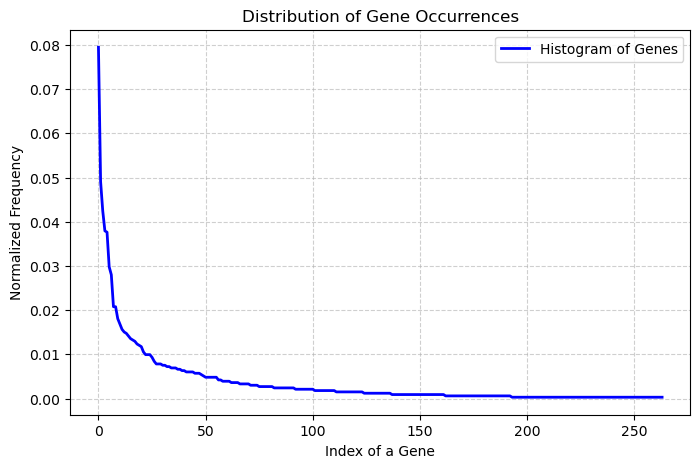

In [27]:
normalized_gene_counts = final_df['Gene'].value_counts().values / final_df['Gene'].value_counts().values.sum()


plt.figure(figsize=(8, 5))
plt.plot(normalized_gene_counts, label="Histogram of Genes", color="b", linewidth=2)


plt.xlabel("Index of a Gene")
plt.ylabel("Normalized Frequency")
plt.title("Distribution of Gene Occurrences")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)


plt.show()

### From the skewed distribution, we say that only very genes have high frequency of occurences, rest all occured only once.

In [28]:
print(f"Total Unique Variations: {final_df['Variation'].nunique()}")
print(final_df['Variation'].value_counts().head(10))

Total Unique Variations: 2996
Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
Q61L                     3
E17K                     3
T58I                     3
Q61R                     3
Name: Variation, dtype: int64


### From the above results, we see that we have 2996 variations, and when the data is split, there is chance that a variation that is present in test data might not be in train data. This could potentially lead to overfitting when this feature is alone used for Classification.

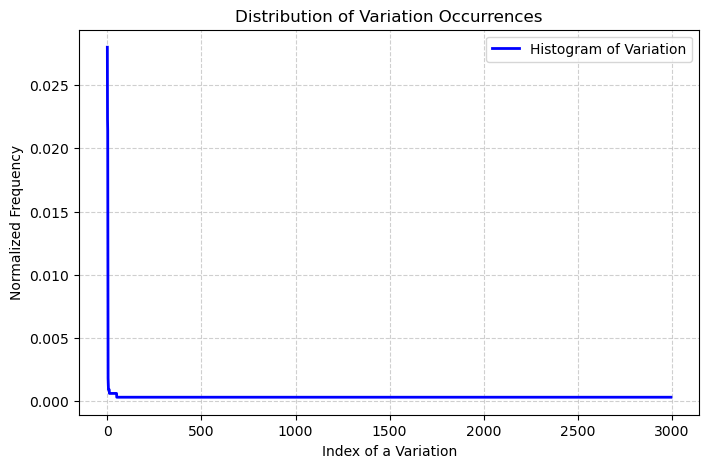

In [31]:
normalized_Variation_counts = final_df['Variation'].value_counts().values / final_df['Variation'].value_counts().values.sum()


plt.figure(figsize=(8, 5))
plt.plot(normalized_Variation_counts, label="Histogram of Variation", color="b", linewidth=2)


plt.xlabel("Index of a Variation")
plt.ylabel("Normalized Frequency")
plt.title("Distribution of Variation Occurrences")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)


plt.show()

### The Variations too followed a skewed distribution, we say that only very genes have high frequency of occurences, rest all occured only once.

In [118]:
#Plots class distribution as a bar chart.

def plot_class_distribution(class_distribution, dataset_name):
    """Plots the percentage distribution of class labels with value annotations."""
    ax = class_distribution.plot(kind='bar', color='tab:blue', figsize=(8, 5))

    plt.xlabel('Class')
    plt.ylabel('Percentage of Data Points per Class')
    plt.title(f"Percentage Distribution of y_i's in  Data")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for i, percentage in enumerate(class_distribution):
        plt.text(i, percentage + 0.5, f"{percentage:.2f}%", ha='center', fontsize=12, fontweight='bold')

    plt.show()

In [119]:
def get_class_distribution(df):
    class_counts = df['Class'].value_counts().sort_index()
    class_percentage = (class_counts / class_counts.sum()) * 100
    return class_percentage

In [120]:
class_distribution = get_class_distribution(final_df)

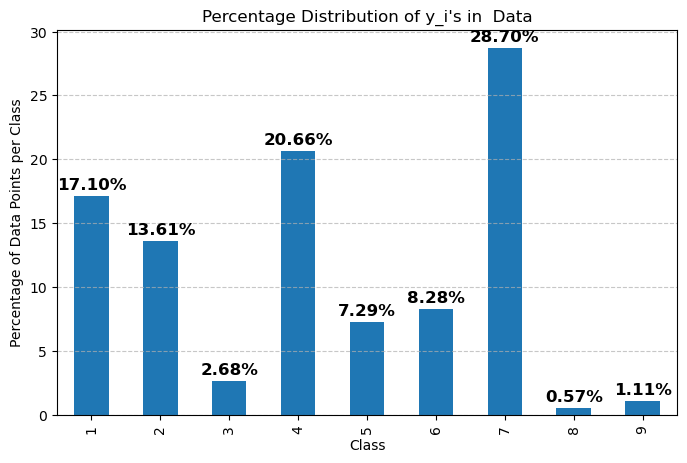

In [121]:
plot_class_distribution(class_distribution, final_df.shape[0])

# Data Preparation

## Train Test split

### Splitting data into train, test and cross validation (64:20:16)

In [32]:
y_true = final_df['Class'].values

#split the data into test and train by maintaining same distribution of output variable 'y_true' [stratify = y_true]
X_train, test_df, y_train, y_test = train_test_split(final_df, y_true, stratify = y_true, test_size = 0.2)
# split the train data into train and cross validation by maintaining same distribution of output variable 'y_trian' [stratify = y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify = y_train, test_size =0.2)

In [33]:
train_df.shape

(2124, 5)

In [34]:
y_train.shape

(2124,)

In [35]:
test_df.shape

(665, 5)

In [36]:
cv_df.shape


(532, 5)

In [37]:
print("Number of data points in train data: ", train_df.shape[0])

Number of data points in train data:  2124


In [38]:
print("NUmber of data points in CV data : ",cv_df.shape[0])
print("NUmber of data points in test data : ",test_df.shape[0])

NUmber of data points in CV data :  532
NUmber of data points in test data :  665


# Distribution of Class labels in train, test, CV datasets.

In [40]:
train_class_distribution = get_class_distribution(train_df)
cv_class_distribution = get_class_distribution(cv_df)
test_class_distribution = get_class_distribution(test_df)

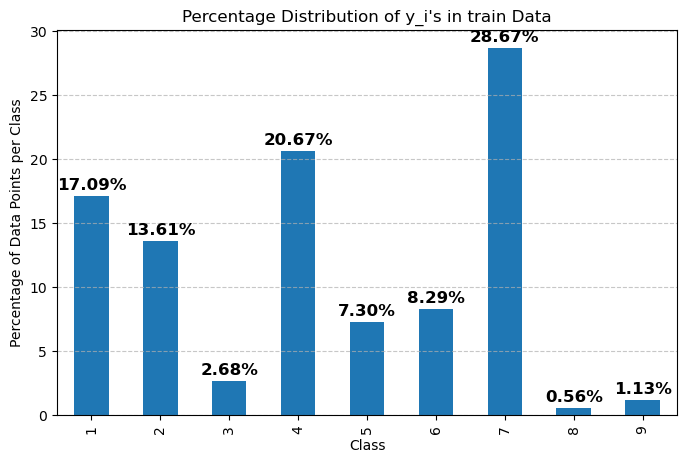

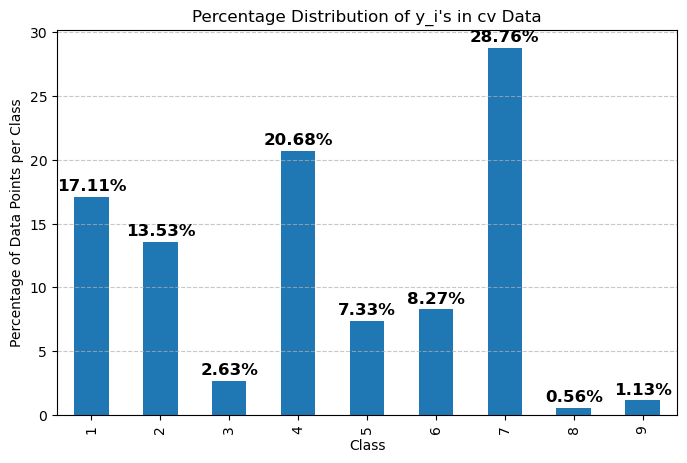

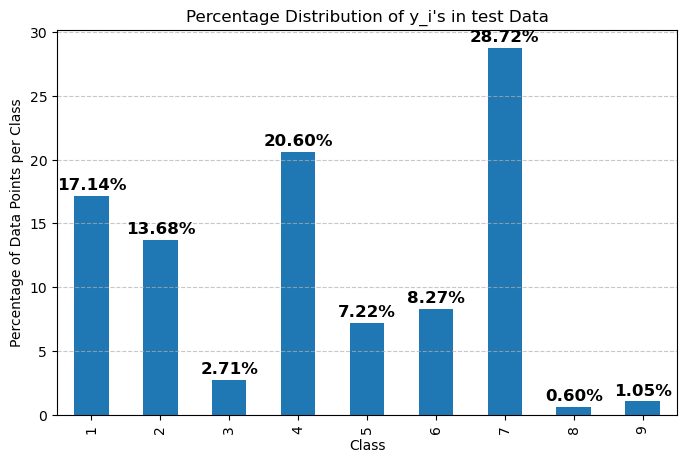

In [42]:
datasets = [("train", train_class_distribution, train_df.shape[0]),
           ("cv", cv_class_distribution, cv_df.shape[0]),
           ("test", test_class_distribution, test_df.shape[0])]

for dataset_name, class_distribution, total_samples in datasets:
    plot_class_distribution(class_distribution, dataset_name)


### From the above plots, the Class label's distribution is same across train, cv and test.

In [43]:
# Defining a function for Confusion Matrix.
def plot_confusion_matrix(test_y,predict_y):
  C= confusion_matrix(test_y, predict_y)

  A=(((C.T)/(C.sum(axis=1))).T)

  B=(C/C.sum(axis=0))

  labels=[1,2,3,4,5,6,7,8,9]

  print("_"*20,"Confusion Matrix", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

  print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()

    # representing B in heatmap format
  print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()


## Categories of Genes and their distribution.

In [44]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes : 229
BRCA1     160
TP53      105
EGFR       89
PTEN       79
BRCA2      73
BRAF       68
KIT        64
ALK        44
ERBB2      42
PIK3CA     37
Name: Gene, dtype: int64


In [45]:
print(unique_genes.shape[0],"different categories of genes are present in data and their distribution as follows")

229 different categories of genes are present in data and their distribution as follows


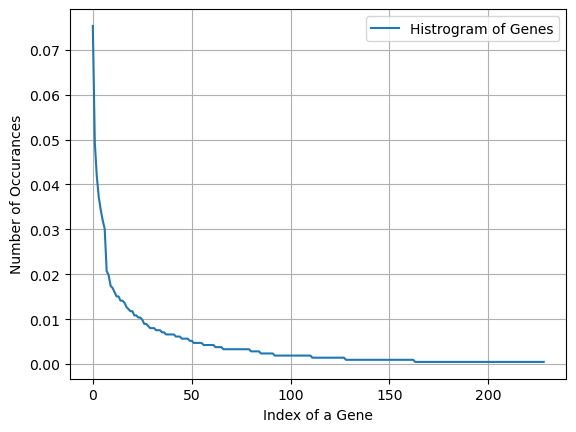

In [46]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

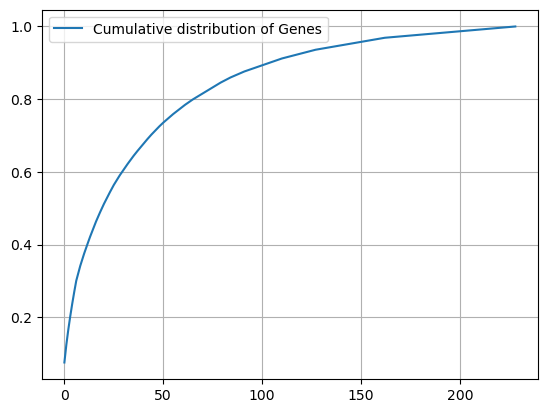

In [47]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

# Featurizing Gene Feature using one hot encoding.

## One hot Encoding of Gene Feature.


In [48]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [49]:
train_df['Gene'].head()

2747     BRAF
1128      MET
2396      NF1
443      TP53
2798    BRCA2
Name: Gene, dtype: object

In [50]:
gene_vectorizer.get_feature_names_out()

array(['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc',
       'ar', 'araf', 'arid1a', 'arid1b', 'asxl1', 'asxl2', 'atm', 'atrx',
       'aurka', 'aurkb', 'bap1', 'bcl10', 'bcl2', 'bcl2l11', 'bcor',
       'braf', 'brca1', 'brca2', 'brd4', 'brip1', 'btk', 'card11',
       'carm1', 'casp8', 'cbl', 'ccnd1', 'ccnd3', 'ccne1', 'cdh1',
       'cdk12', 'cdk4', 'cdk6', 'cdk8', 'cdkn1a', 'cdkn1b', 'cdkn2a',
       'cdkn2b', 'cdkn2c', 'chek2', 'cic', 'crebbp', 'ctcf', 'ctla4',
       'ctnnb1', 'ddr2', 'dicer1', 'dnmt3a', 'dnmt3b', 'egfr', 'eif1ax',
       'elf3', 'ep300', 'epas1', 'epcam', 'erbb2', 'erbb3', 'erbb4',
       'ercc2', 'ercc3', 'ercc4', 'erg', 'errfi1', 'esr1', 'etv6',
       'ewsr1', 'ezh2', 'fam58a', 'fanca', 'fat1', 'fbxw7', 'fgf19',
       'fgf4', 'fgfr1', 'fgfr2', 'fgfr3', 'flt1', 'flt3', 'foxa1',
       'foxo1', 'foxp1', 'gata3', 'gli1', 'gna11', 'gnaq', 'gnas',
       'h3f3a', 'hla', 'hnf1a', 'hras', 'idh1', 'idh2', 'igf1r', 'jak1',
       'jak2', 'jun', 'kdm5a

In [51]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 228)


How many data points in Test and CV datasets are covered by the 220 genes in train dataset?

In [52]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)


Ans
1. In test data 629 out of 665 : 94.58646616541353
2. In cross validation data 513 out of  532 : 96.42857142857143


Variation is a categorical variable, so
how many categories are present?





In [53]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1941
Truncating Mutations    57
Deletion                44
Amplification           40
Fusions                 23
Overexpression           4
Q61R                     3
E17K                     3
T58I                     3
A146V                    2
Q61H                     2
Name: Variation, dtype: int64


In [54]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1941 different categories of variations in the train data, and they are distibuted as follows


How to featurize this Variation feature ?

We are featurizing this variation feature using One hot encoding




In [55]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [56]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1975)


How many data points in Test and CV datasets are covered by the variations in train dataset?

In [57]:
print(" How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

 How many data points are covered by total  1941  genes in test and cross validation data sets?
Ans
1. In test data 76 out of 665 : 11.428571428571429
2. In cross validation data 56 out of  532 : 10.526315789473683


## How many unique words present?

In [58]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

Building a CountVectorizer with all the words that occured minimum 3 times in train data

In [59]:
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features= text_vectorizer.get_feature_names_out()


train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1


text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53571


Normalizing the features

In [60]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)


test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])

test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)


cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [61]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [62]:
print(Counter(sorted_text_occur))

Counter({3: 5374, 4: 4296, 6: 2641, 5: 2580, 9: 2200, 7: 1815, 8: 1748, 10: 1490, 12: 1440, 11: 1272, 13: 954, 15: 889, 14: 839, 16: 733, 24: 665, 18: 646, 20: 570, 19: 552, 21: 530, 17: 513, 22: 453, 27: 441, 23: 408, 25: 399, 30: 387, 31: 385, 26: 374, 32: 322, 28: 320, 43: 302, 29: 270, 36: 268, 33: 266, 34: 264, 48: 231, 35: 225, 39: 224, 40: 221, 38: 217, 37: 216, 42: 213, 45: 197, 41: 195, 50: 185, 44: 173, 46: 169, 47: 162, 54: 155, 51: 152, 55: 143, 57: 140, 52: 138, 49: 134, 63: 131, 56: 129, 69: 123, 60: 123, 58: 122, 53: 120, 65: 117, 66: 114, 59: 108, 62: 105, 72: 102, 82: 100, 64: 98, 78: 96, 70: 96, 74: 94, 61: 93, 76: 91, 86: 89, 73: 88, 84: 87, 81: 82, 80: 81, 68: 80, 67: 78, 79: 76, 88: 72, 77: 72, 85: 70, 102: 68, 97: 68, 108: 67, 104: 67, 91: 66, 90: 66, 83: 66, 75: 66, 95: 64, 87: 64, 71: 63, 100: 62, 92: 62, 93: 58, 112: 57, 98: 56, 105: 55, 99: 55, 118: 54, 101: 52, 94: 52, 96: 51, 128: 50, 124: 50, 117: 49, 113: 49, 131: 48, 126: 47, 115: 46, 89: 46, 140: 43, 123

How many words of train data are present in test and CV data?

In [63]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names_out()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [64]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.5 % of word of test data appeared in train data
98.495 % of word of Cross Validation appeared in train data


# Data Preparation

## Gene, Var, text One hot encoded

In [65]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [66]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55774)
(number of data points * number of features) in test data =  (665, 55774)
(number of data points * number of features) in cross validation data = (532, 55774)


### Vectorizing Text with TFIDF

In [67]:
tfidf_vectorizer = TfidfVectorizer(min_df=3)
train_text_feature_tfidf = tfidf_vectorizer.fit_transform(train_df['TEXT'])

train_text_tfidf_features= tfidf_vectorizer.get_feature_names_out()

train_text_fea_counts = train_text_feature_tfidf.sum(axis=0).A1


text_fea_dict = dict(zip(list(train_text_tfidf_features),train_text_fea_counts))

print(f"TF-IDF transformation completed. Vocabulary size: {len(train_text_tfidf_features)}")



TF-IDF transformation completed. Vocabulary size: 53571


In [68]:

cv_text_feature_tfidf = tfidf_vectorizer.transform(cv_df['TEXT'])

test_text_feature_tfidf = tfidf_vectorizer.transform(test_df['TEXT'])


train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

cv_text_feature_tfidf = normalize(cv_text_feature_tfidf, axis =0)

test_text_feature_tfidf = normalize(test_text_feature_tfidf, axis =0)

In [69]:
train_x_tfidf = hstack((train_gene_var_onehotCoding,train_text_feature_tfidf )).tocsr()
train_y = np.array(list(train_df['Class']))

cv_tfidf = hstack((cv_gene_var_onehotCoding,cv_text_feature_tfidf )).tocsr()
cv_y = np.array(list(cv_df['Class']))

test_tfidf = hstack((test_gene_var_onehotCoding,test_text_feature_tfidf)).tocsr()
test_y = np.array(list(test_df['Class']))

In [70]:
print("Tfidf features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf.shape)
print("(number of data points * number of features) in cross validation data = ", cv_tfidf.shape)
print("(number of data points * number of features) in test data =", test_tfidf.shape)

Tfidf features :
(number of data points * number of features) in train data =  (2124, 55774)
(number of data points * number of features) in cross validation data =  (532, 55774)
(number of data points * number of features) in test data = (665, 55774)


### Vectorizing text with max features 1000.

In [71]:

tfidf_vectorizer_maxft = TfidfVectorizer(max_features = 1000, min_df =3)
train_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.fit_transform(train_df['TEXT'])
train_text_features_tfidf_max_features = tfidf_vectorizer_maxft.get_feature_names_out()
train_text_fea_max_ft_counts = train_text_feature_tfidf_maxft.sum(axis=0).A1
text_fea_dict_max_ft = dict(zip(list(train_text_features_tfidf_max_features), train_text_fea_max_ft_counts))
print("Total number of unique words in train data :", len(train_text_features_tfidf_max_features))


Total number of unique words in train data : 1000


In [72]:
cv_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.transform(cv_df['TEXT'])
test_text_feature_tfidf_maxft = tfidf_vectorizer_maxft.transform(test_df['TEXT'])
train_text_feature_tfidf_maxft = normalize(train_text_feature_tfidf_maxft, axis =0)
cv_text_feature_tfidf_maxft = normalize(cv_text_feature_tfidf_maxft, axis =0)
test_text_feature_tfidf_maxft = normalize(test_text_feature_tfidf_maxft, axis =0)

In [73]:
train_x_tfidf_maxft = hstack((train_gene_var_onehotCoding,train_text_feature_tfidf_maxft )).tocsr()
train_y = np.array(list(train_df['Class']))

cv_tfidf_maxft = hstack((cv_gene_var_onehotCoding,cv_text_feature_tfidf_maxft)).tocsr()
cv_y = np.array(list(cv_df['Class']))

test_tfidf_maxft = hstack((test_gene_var_onehotCoding,test_text_feature_tfidf_maxft)).tocsr()
test_y = np.array(list(test_df['Class']))

In [74]:
print("Tfidf Max_1000 features :")
print("(number of data points * number of features) in train data = ", train_x_tfidf_maxft.shape)
print("(number of data points * number of features) in cross validation data = ", cv_tfidf_maxft.shape)
print("(number of data points * number of features) in test data =", test_tfidf_maxft.shape)

Tfidf Max_1000 features :
(number of data points * number of features) in train data =  (2124, 3203)
(number of data points * number of features) in cross validation data =  (532, 3203)
(number of data points * number of features) in test data = (665, 3203)


# Machine Learning Models

In [75]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we will provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [76]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

# Logistic Regresssion

## With class balancing

# Hyper parameter tuning

for alpha = 1e-06
Log Loss : 1.2955046907390912
for alpha = 1e-05
Log Loss : 1.2714340337709458
for alpha = 0.0001
Log Loss : 1.0930633669386007
for alpha = 0.001
Log Loss : 1.0746297187334435
for alpha = 0.01
Log Loss : 1.1591972894302192
for alpha = 0.1
Log Loss : 1.4606706813107688
for alpha = 1
Log Loss : 1.684163987980804
for alpha = 10
Log Loss : 1.7099575965126108
for alpha = 100
Log Loss : 1.712583310756625


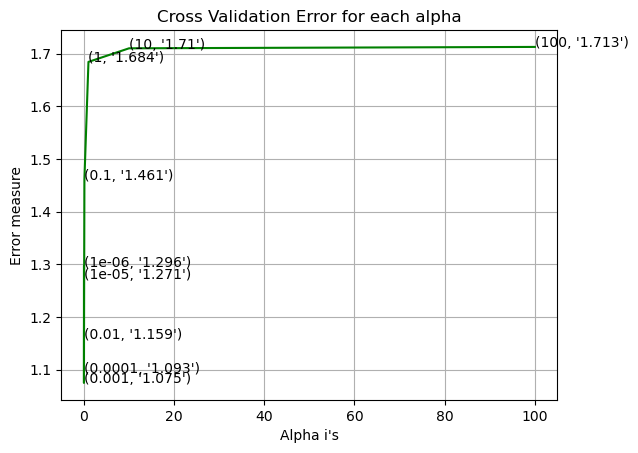

For Train data with alpha=3, Log Loss: 0.5294823051919232
For Cross Validation data with alpha=3, Log Loss: 1.0746297187334435
For Test data with alpha=3, Log Loss: 1.0890161709077273


In [137]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)
    print("Log Loss :",log_loss_value)



fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0890161709077273
Number of mis-classified points : 0.37142857142857144
____________________ Confusion Matrix --------------------


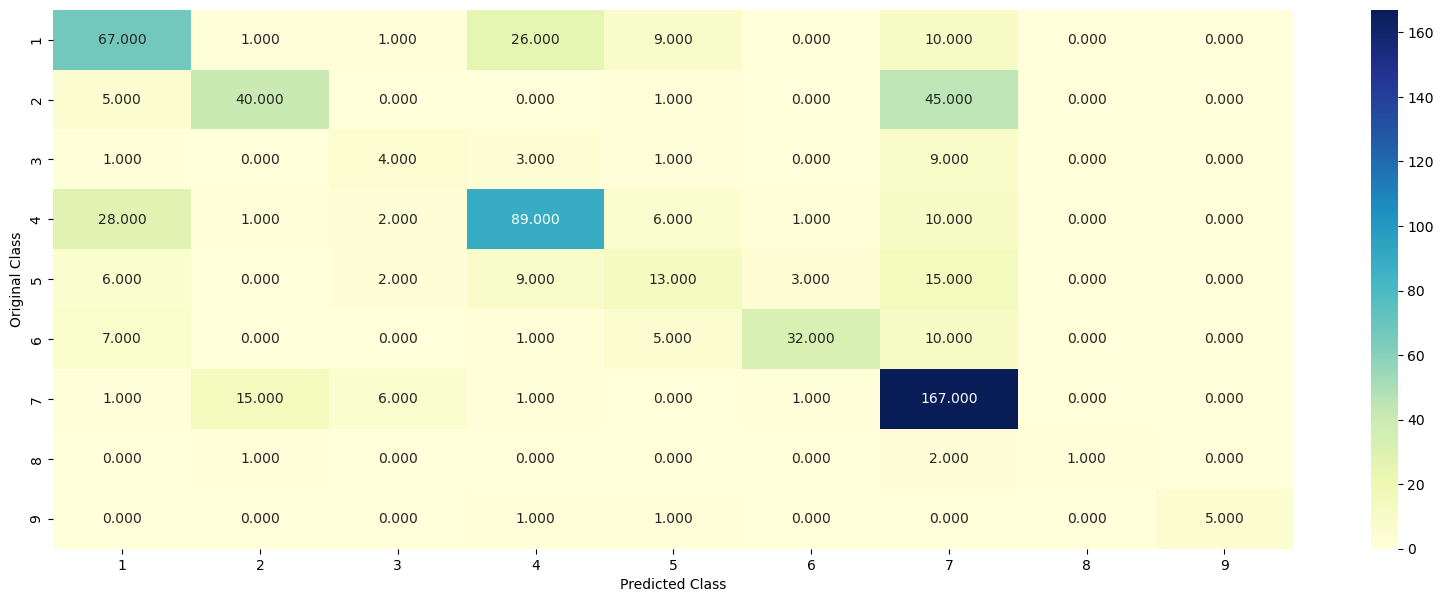

-------------------- Precision matrix (Columm Sum=1) --------------------


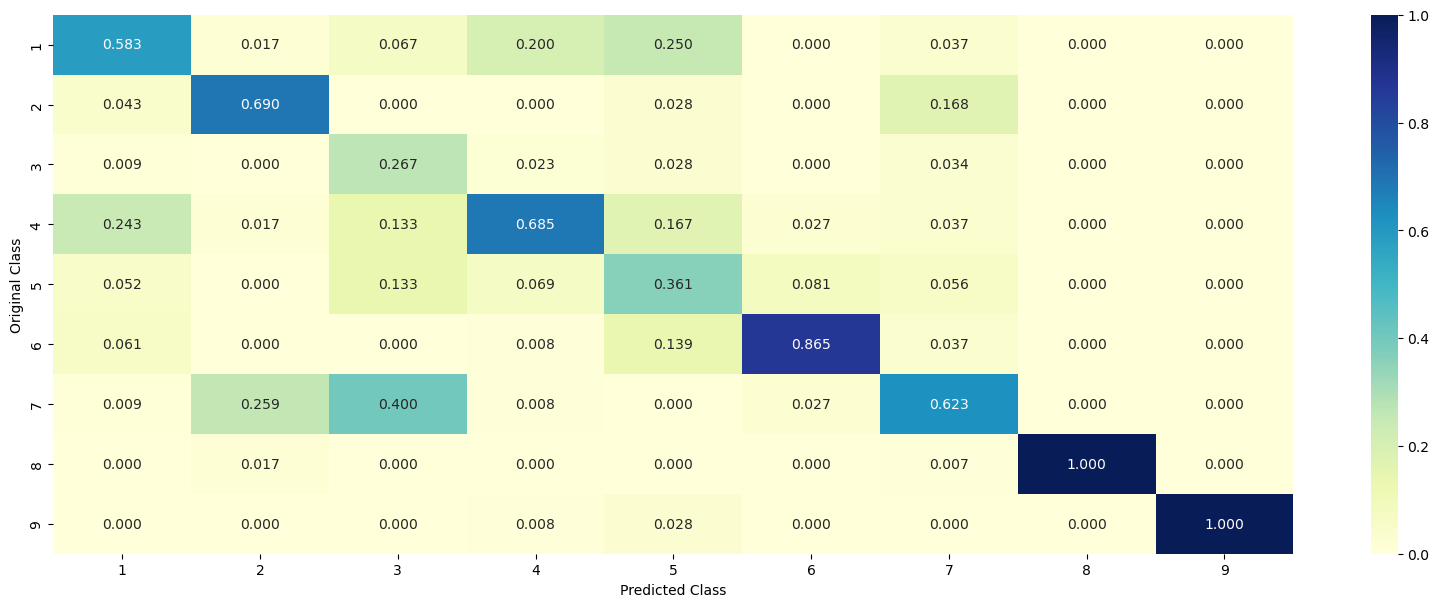

-------------------- Recall matrix (Row sum=1) --------------------


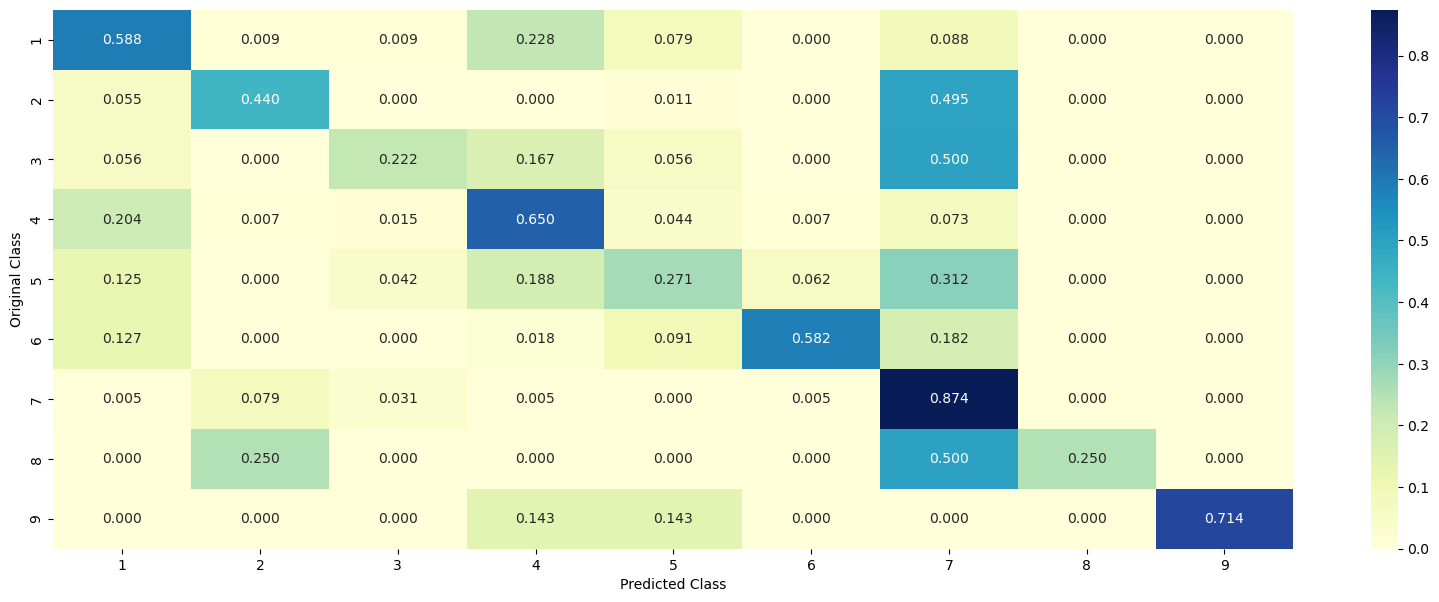

In [138]:
# Testing the model with best hyper paramters

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

In [139]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100

no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]



Predicted Class : 7
Predicted Class Probabilities: [[0.0858 0.1406 0.0143 0.2508 0.0398 0.0338 0.4201 0.007  0.0078]]
Actual Class : 7


In [140]:


test_point_index = 22
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]



Predicted Class : 2
Predicted Class Probabilities: [[0.0146 0.9059 0.0045 0.0238 0.0131 0.0085 0.0205 0.0054 0.0038]]
Actual Class : 2


# With TFIDF Features

For alpha = 1e-06
Log Loss: 1.2641131061169213
For alpha = 1e-05
Log Loss: 1.2307517699134596
For alpha = 0.0001
Log Loss: 1.0550107190803852
For alpha = 0.001
Log Loss: 1.0940660092511652
For alpha = 0.01
Log Loss: 1.1713507073122116
For alpha = 0.1
Log Loss: 1.2787548732152447
For alpha = 1
Log Loss: 1.4489235662564521
For alpha = 10
Log Loss: 1.4828726500398575
For alpha = 100
Log Loss: 1.4867660432939327


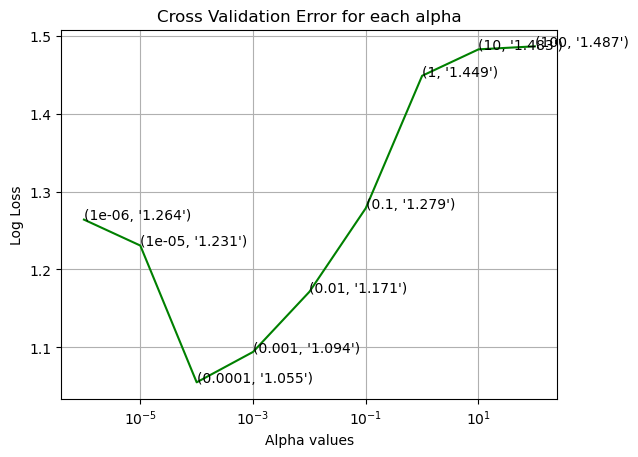

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.48628871188741213
For Cross Validation data with alpha=0.0001, Log Loss: 1.0550107190803852
For Test data with alpha=0.0001, Log Loss: 1.04431932716412


In [141]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []


for i in alpha:
    print("For alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)


    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)

    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  
plt.show()


best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)


clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.04431932716412
Number of mis-classified points : 0.3533834586466165
____________________ Confusion Matrix --------------------


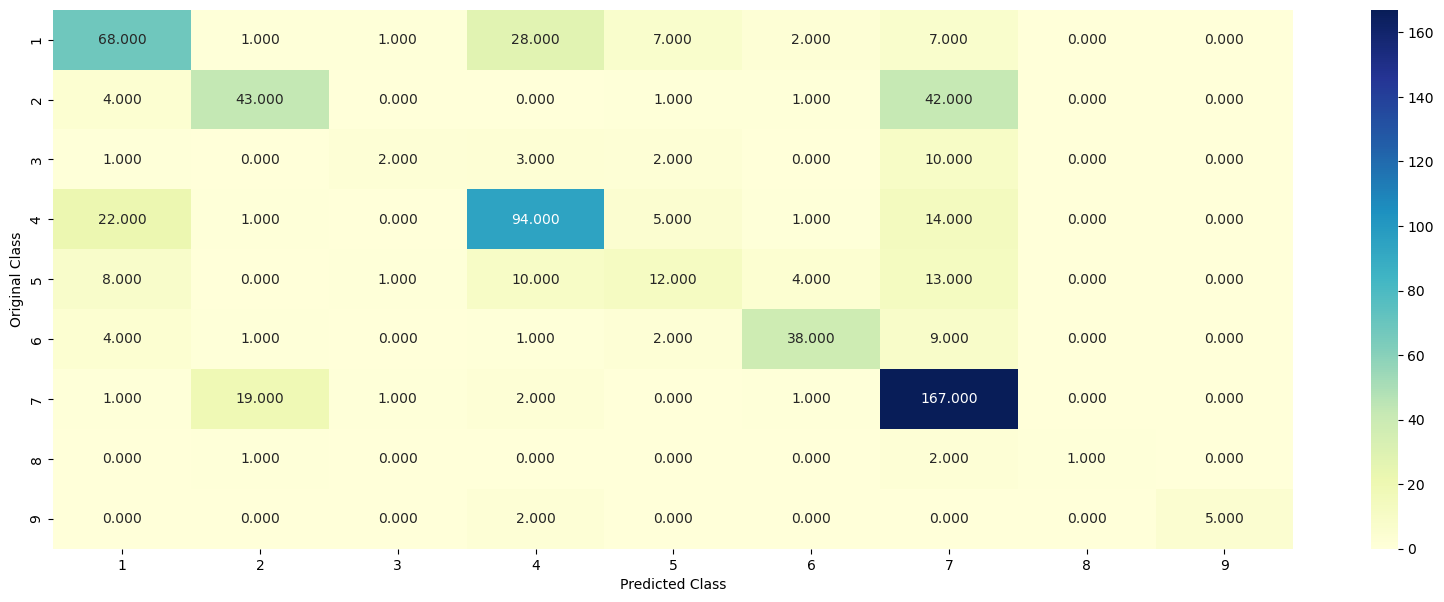

-------------------- Precision matrix (Columm Sum=1) --------------------


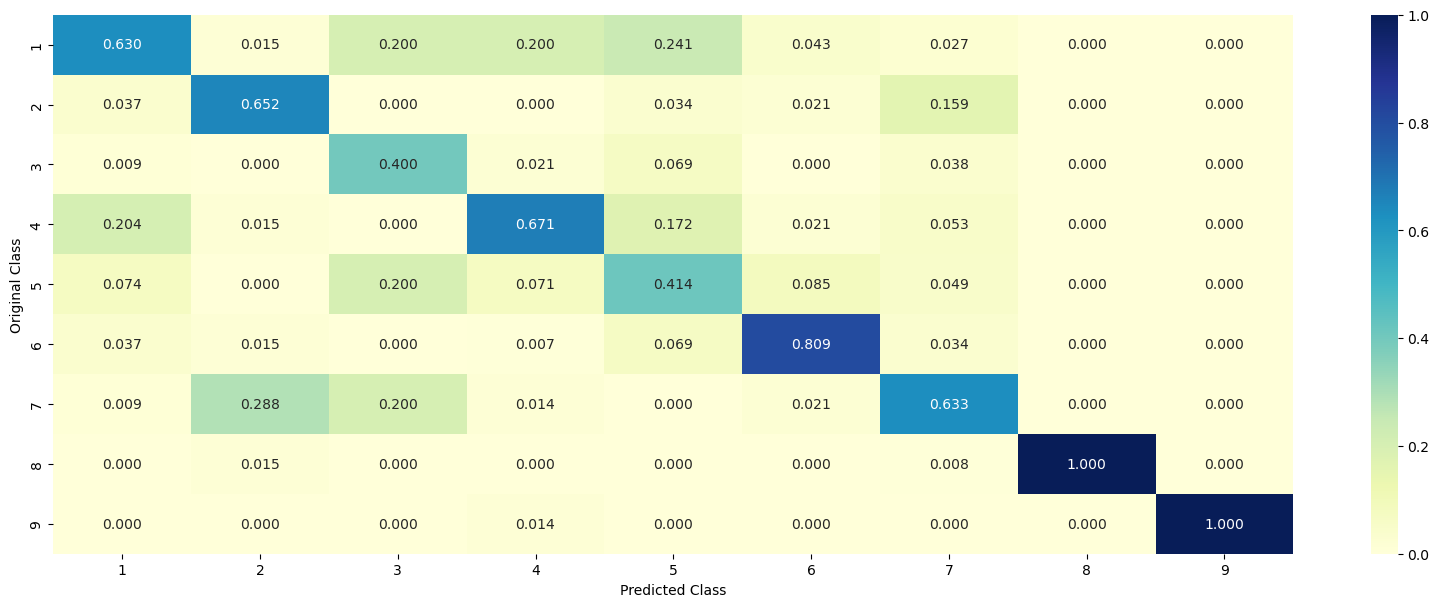

-------------------- Recall matrix (Row sum=1) --------------------


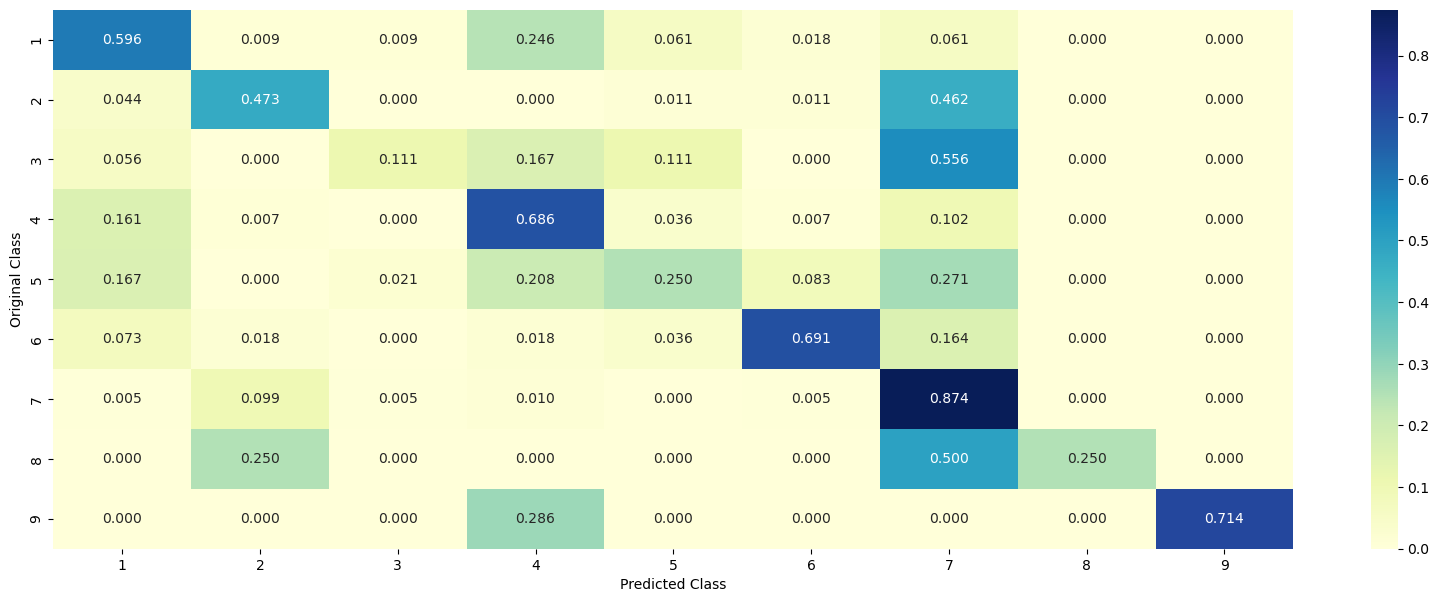

In [142]:
clf = SGDClassifier(class_weight='balanced',alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_tfidf, test_y, clf)

In [144]:
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf,train_y)
test_point_index = 100

no_feature = 500
predicted_cls = sig_clf.predict(test_tfidf[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_tfidf[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0534 0.0897 0.0193 0.3069 0.041  0.0255 0.4483 0.0068 0.0092]]
Actual Class : 7


### TFIDF with top 1000 features


For alpha = 1e-06
Log Loss: 1.1121807884440842
For alpha = 1e-05
Log Loss: 1.0538215283478425
For alpha = 0.0001
Log Loss: 1.0113293108345398
For alpha = 0.001
Log Loss: 1.0395761251799442
For alpha = 0.01
Log Loss: 1.2100246702504394
For alpha = 0.1
Log Loss: 1.5366440904195304
For alpha = 1
Log Loss: 1.6877673985467514
For alpha = 10
Log Loss: 1.7084092902303774
For alpha = 100
Log Loss: 1.710861708638392


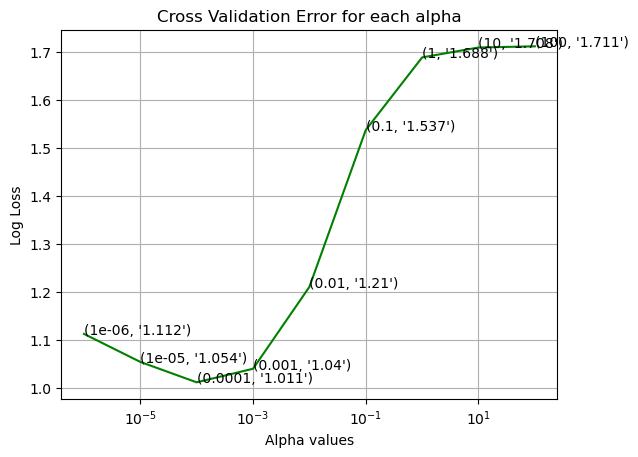

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.3969153005183553
For Cross Validation data with alpha=0.0001, Log Loss: 1.0113293108345398
For Test data with alpha=0.0001, Log Loss: 0.9892112244785204


In [145]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 0.9892112244785204
Number of mis-classified points : 0.37142857142857144
____________________ Confusion Matrix --------------------


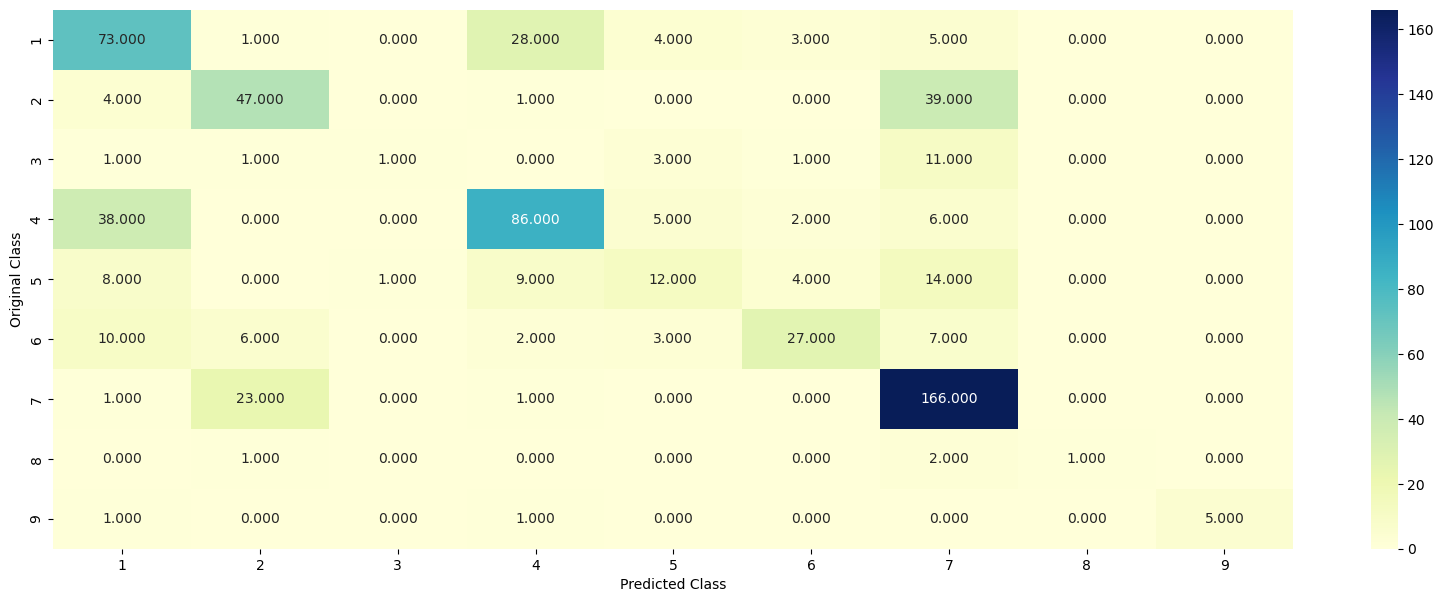

-------------------- Precision matrix (Columm Sum=1) --------------------


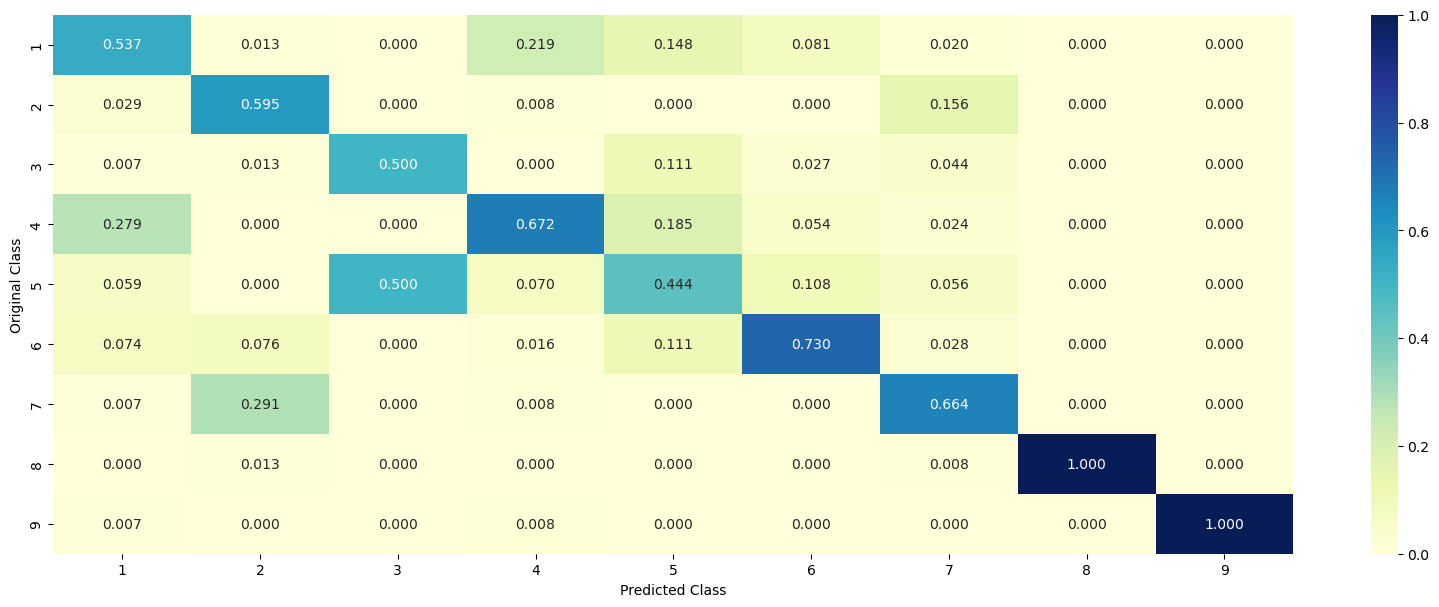

-------------------- Recall matrix (Row sum=1) --------------------


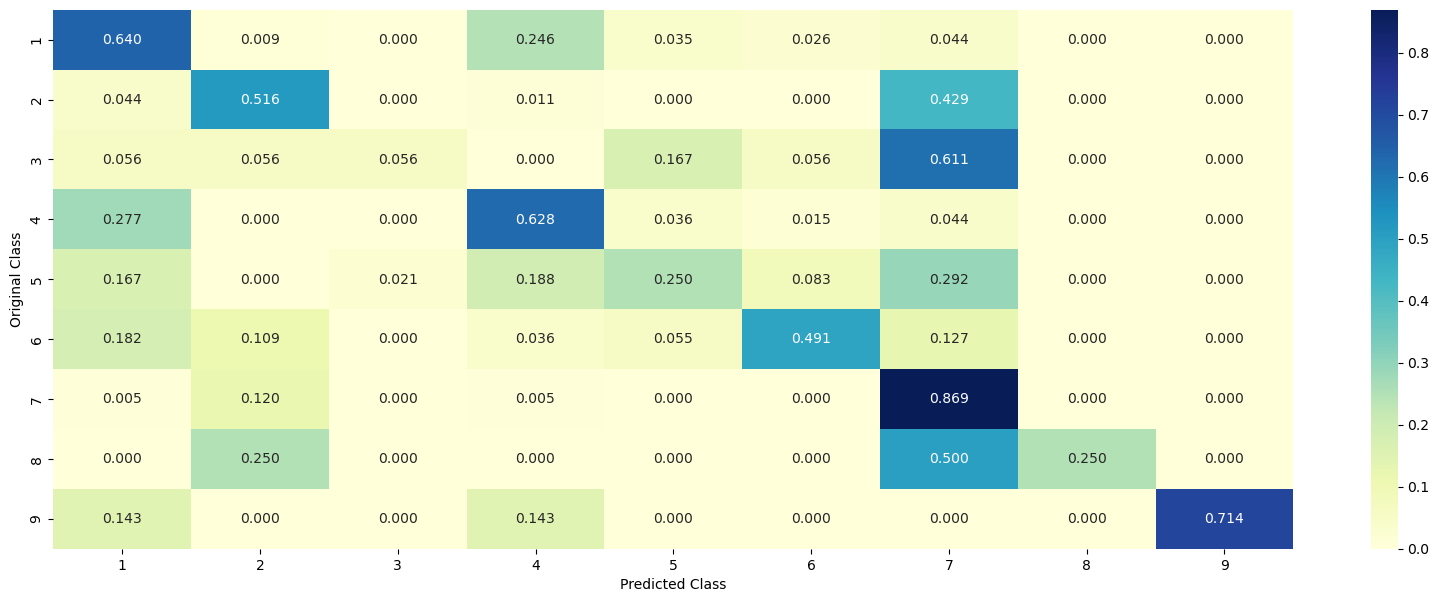

In [146]:
clf = SGDClassifier(class_weight='balanced',alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

In [147]:
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf_maxft,train_y)
test_point_index = 100

no_feature = 500
predicted_cls = sig_clf.predict(test_tfidf_maxft[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_tfidf_maxft[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])

Predicted Class : 7
Predicted Class Probabilities: [[0.0397 0.2396 0.0068 0.0837 0.0245 0.0035 0.588  0.0057 0.0085]]
Actual Class : 7


## Without Class balancing

for alpha = 1e-06
Log Loss : 1.3049915150102183
for alpha = 1e-05
Log Loss : 1.2572660269545488
for alpha = 0.0001
Log Loss : 1.1012530916672822
for alpha = 0.001
Log Loss : 1.0846419475649074
for alpha = 0.01
Log Loss : 1.1706962342415947
for alpha = 0.1
Log Loss : 1.3120858573583827
for alpha = 1
Log Loss : 1.5718343699757218
for alpha = 10
Log Loss : 1.6223400641787251
for alpha = 100
Log Loss : 1.6277423776092832


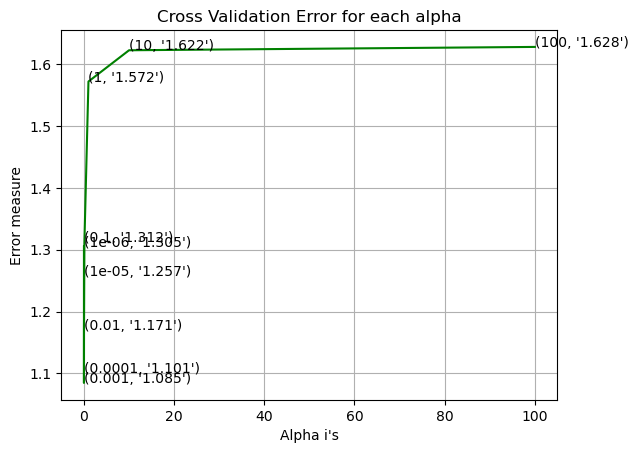

For Train data with alpha=3, Log Loss: 0.525359863807362
For Cross Validation data with alpha=3, Log Loss: 1.0846419475649074
For Test data with alpha=3, Log Loss: 1.0988393326269983


In [148]:
# Hyper parameter tuning

alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)
    print("Log Loss :",log_loss_value)



fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier( alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")


Log loss : 1.6149444451523356
Number of mis-classified points : 0.5503759398496241
____________________ Confusion Matrix --------------------


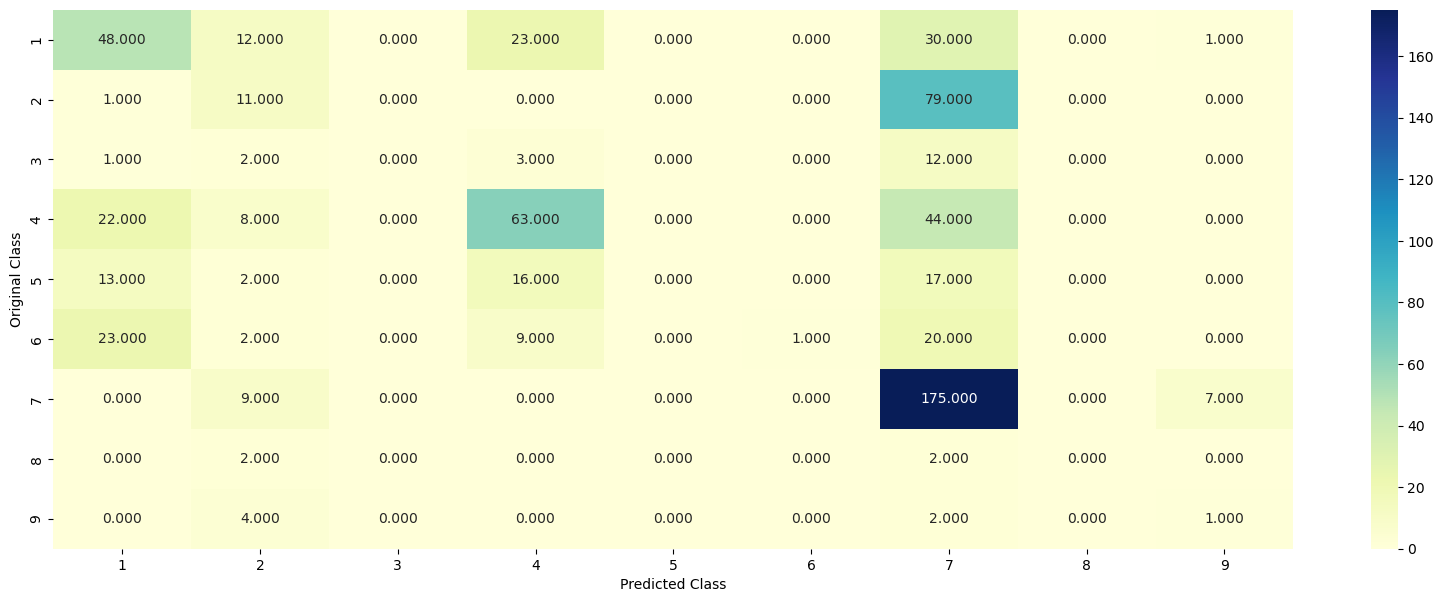

-------------------- Precision matrix (Columm Sum=1) --------------------


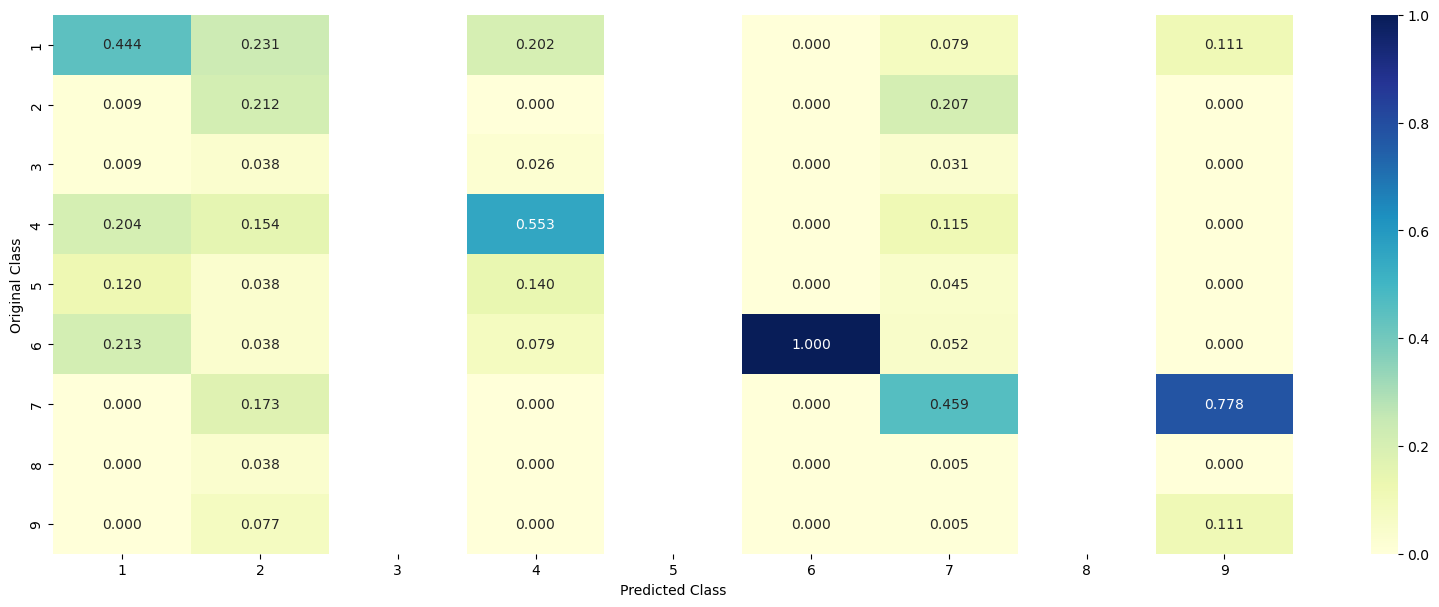

-------------------- Recall matrix (Row sum=1) --------------------


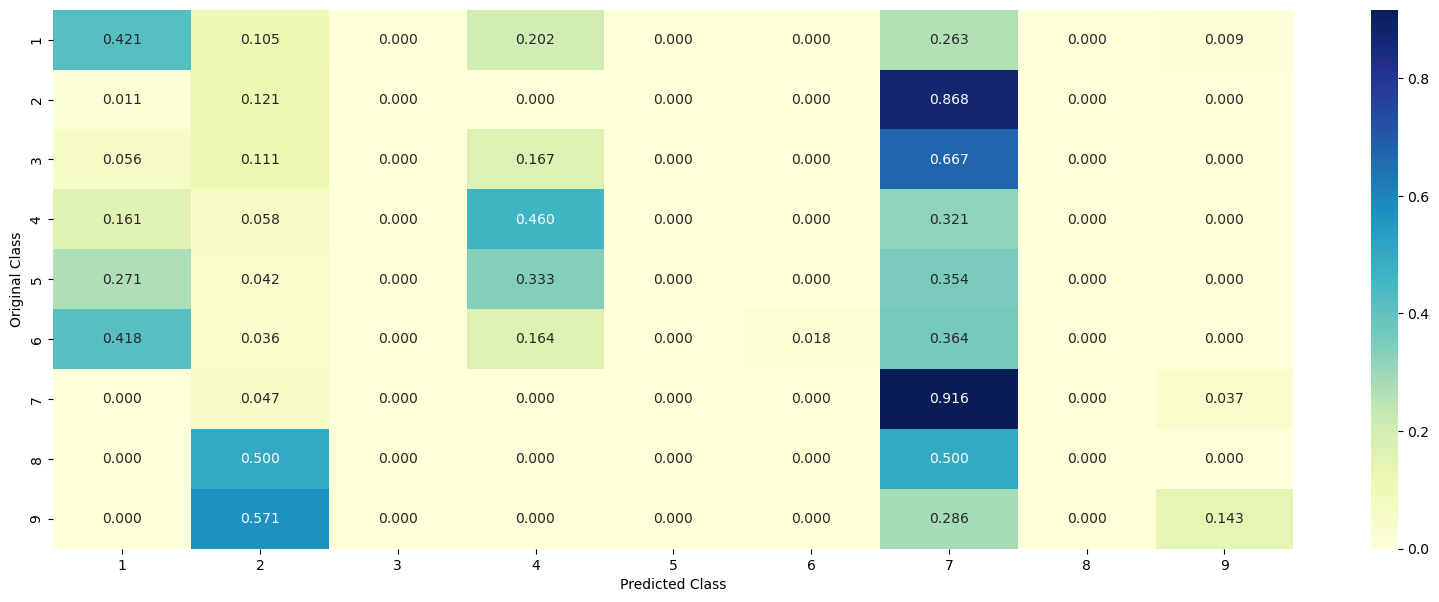

In [149]:
# Testing the model with  best hyper parameters

clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, clf)

In [150]:

clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 30
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]



Predicted Class : 4
Predicted Class Probabilities: [[2.000e-04 1.600e-03 2.090e-02 7.828e-01 3.000e-04 1.898e-01 9.000e-04
  3.500e-03 0.000e+00]]
Actual Class : 3


In [151]:
test_point_index = 15
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]



Predicted Class : 7
Predicted Class Probabilities: [[0.0332 0.1459 0.0145 0.0607 0.0488 0.0304 0.6545 0.0066 0.0053]]
Actual Class : 7


### Tfidf text features

For alpha = 1e-06
Log Loss: 1.2431036217002058
For alpha = 1e-05
Log Loss: 1.2042736269062537
For alpha = 0.0001
Log Loss: 1.078534007672014
For alpha = 0.001
Log Loss: 1.1082788595464137
For alpha = 0.01
Log Loss: 1.2212325944811662
For alpha = 0.1
Log Loss: 1.2696211991874893
For alpha = 1
Log Loss: 1.3751703356356233
For alpha = 10
Log Loss: 1.4222780258593768
For alpha = 100
Log Loss: 1.427923738636111


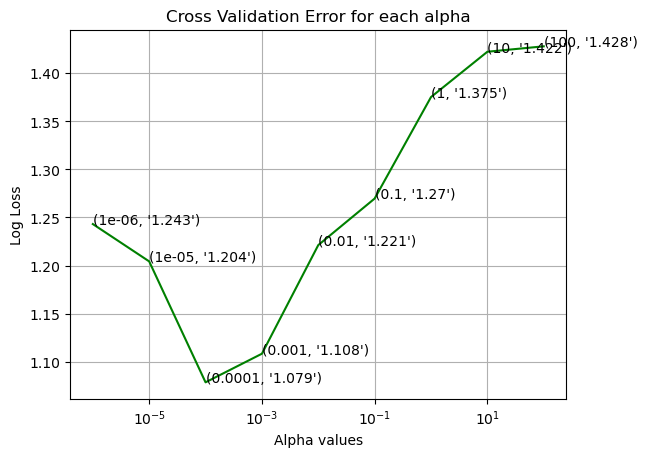

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.464031875230213
For Cross Validation data with alpha=0.0001, Log Loss: 1.078534007672014
For Test data with alpha=0.0001, Log Loss: 1.0450706725778405


In [152]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier( alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.078534007672014
Number of mis-classified points : 0.33646616541353386
____________________ Confusion Matrix --------------------


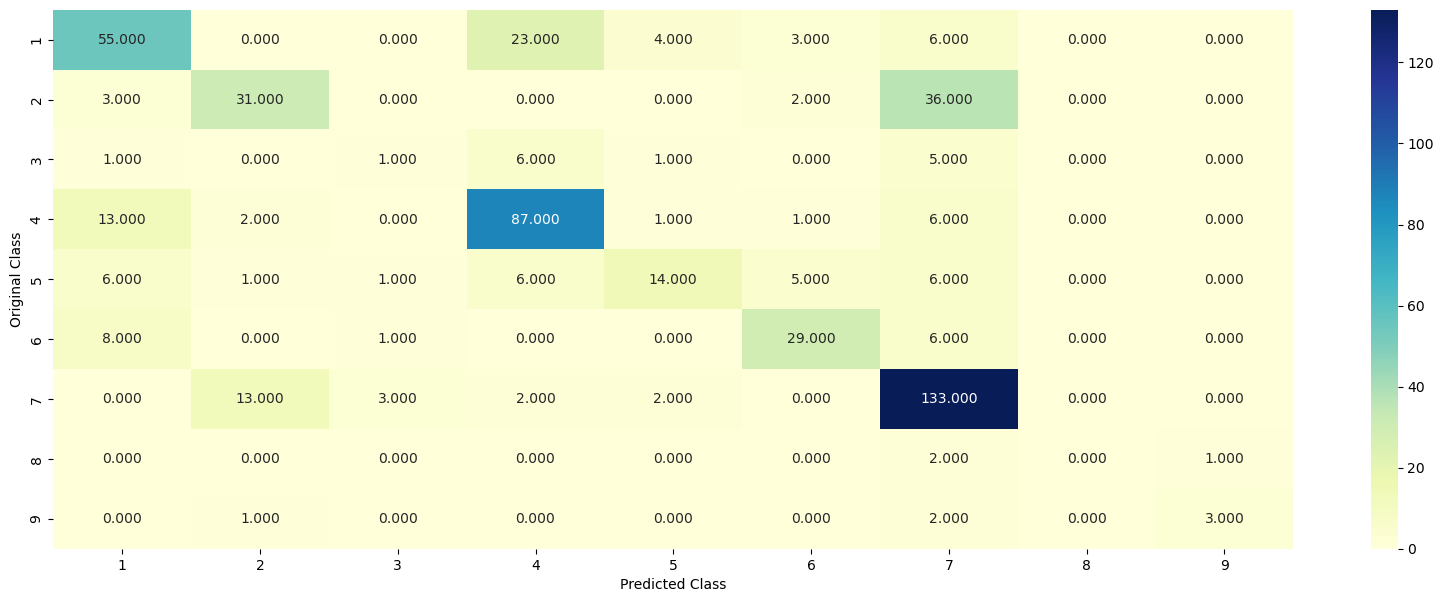

-------------------- Precision matrix (Columm Sum=1) --------------------


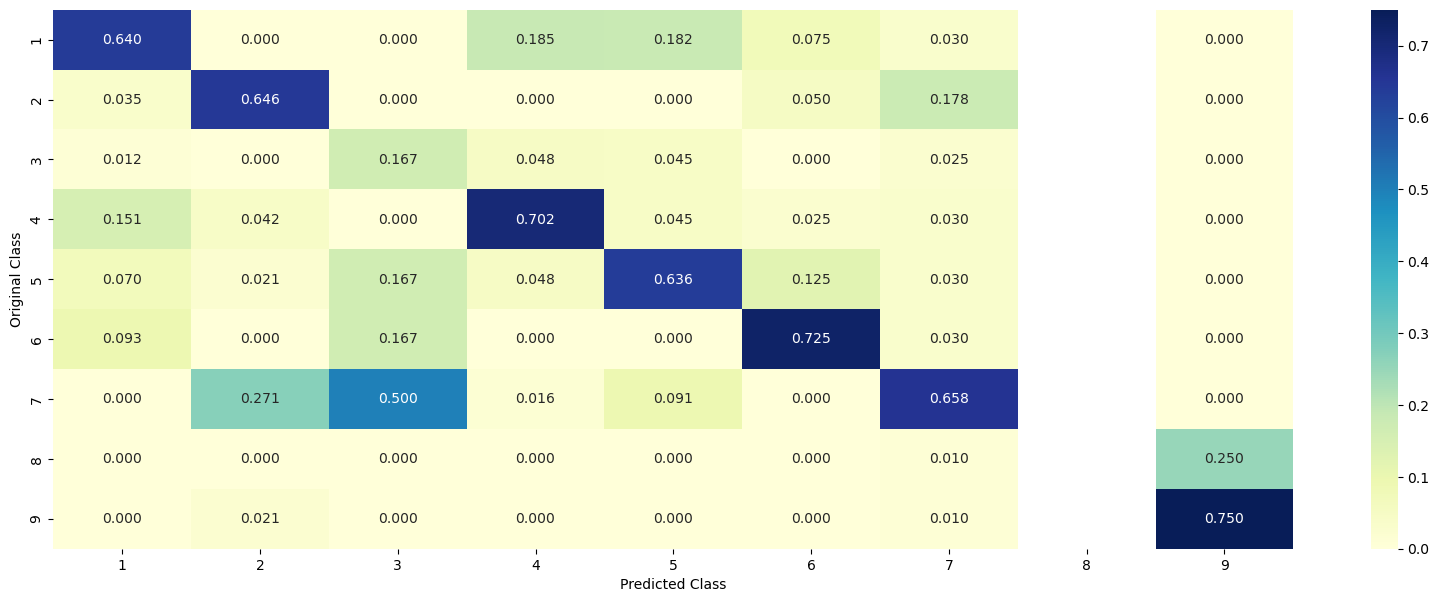

-------------------- Recall matrix (Row sum=1) --------------------


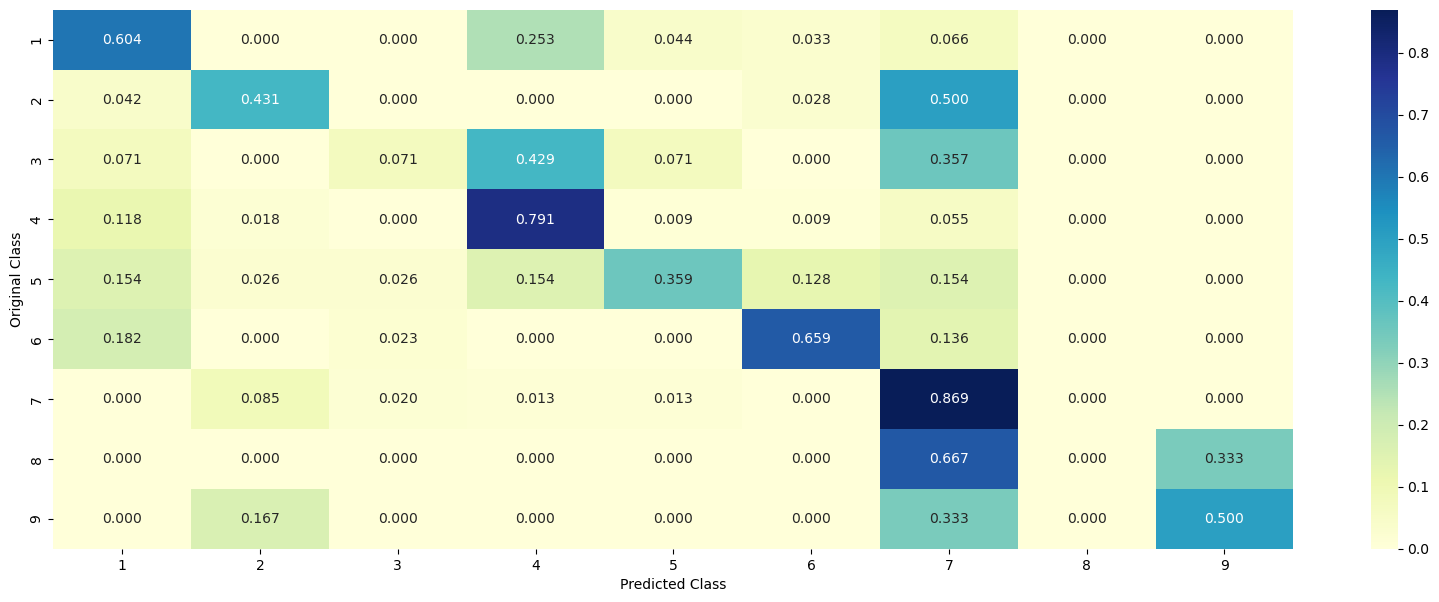

In [153]:
clf = SGDClassifier(alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, cv_tfidf, cv_y, clf)

### TFIDF with top 1000 features

For alpha = 1e-06
Log Loss: 1.1253879049897462
For alpha = 1e-05
Log Loss: 1.0805299474704688
For alpha = 0.0001
Log Loss: 1.0307436179128415
For alpha = 0.001
Log Loss: 1.1074515138614713
For alpha = 0.01
Log Loss: 1.3280599981191101
For alpha = 0.1
Log Loss: 1.686310597784909
For alpha = 1
Log Loss: 1.7764827683396078
For alpha = 10
Log Loss: 1.7876226903598156
For alpha = 100
Log Loss: 1.7889352905587192


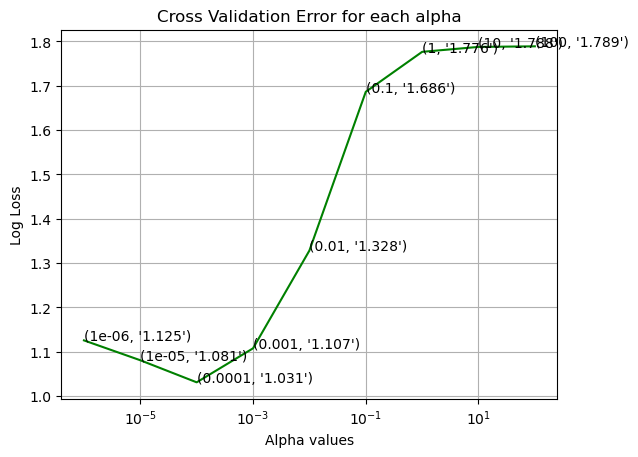

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.3856158367271182
For Cross Validation data with alpha=0.0001, Log Loss: 1.0307436179128415
For Test data with alpha=0.0001, Log Loss: 1.0091262360467026


In [155]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Log Loss
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)

    # Clip probabilities to prevent log(0) errors
    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)

    # Compute Log Loss
    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

#Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]


print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier( alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)
    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)  # Avoid log(0) error

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0091262360467026
Number of mis-classified points : 0.36541353383458647
____________________ Confusion Matrix --------------------


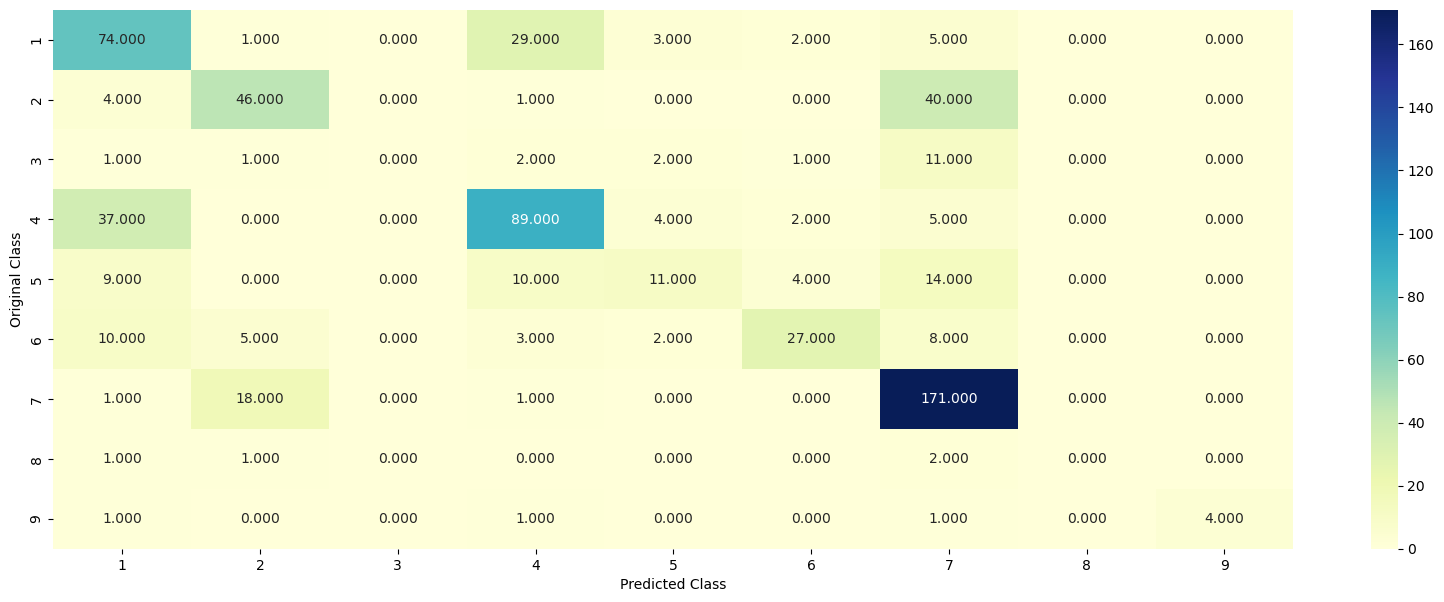

-------------------- Precision matrix (Columm Sum=1) --------------------


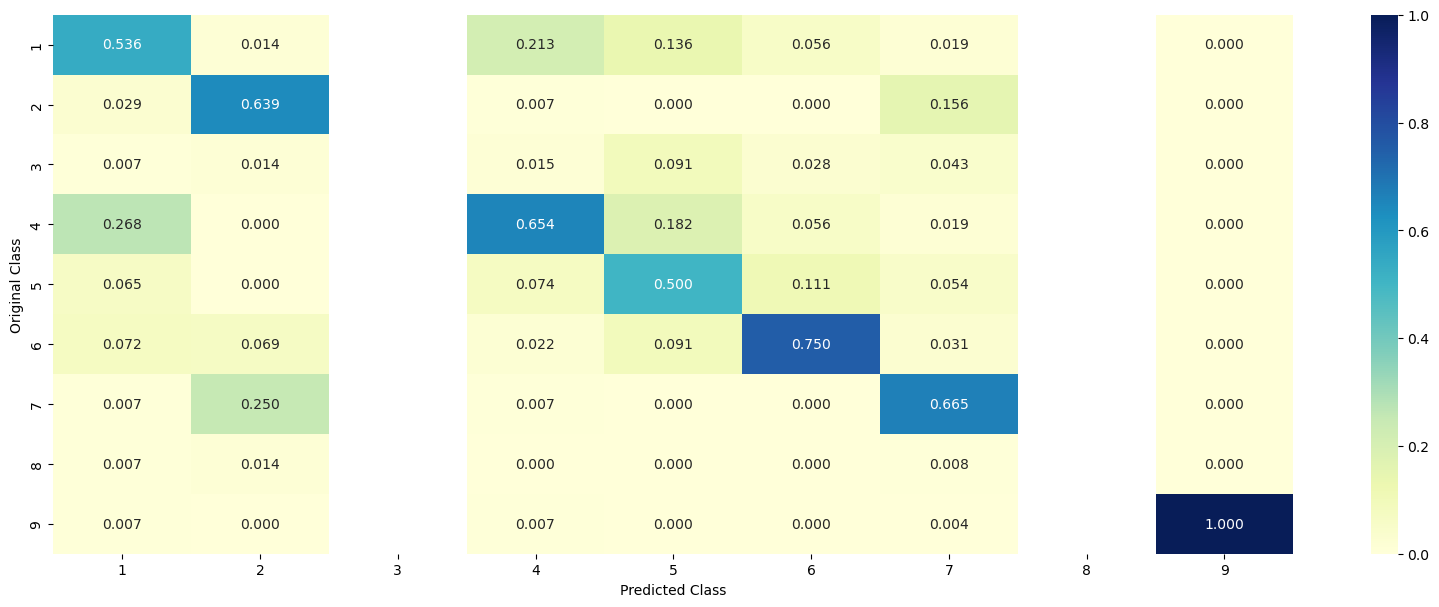

-------------------- Recall matrix (Row sum=1) --------------------


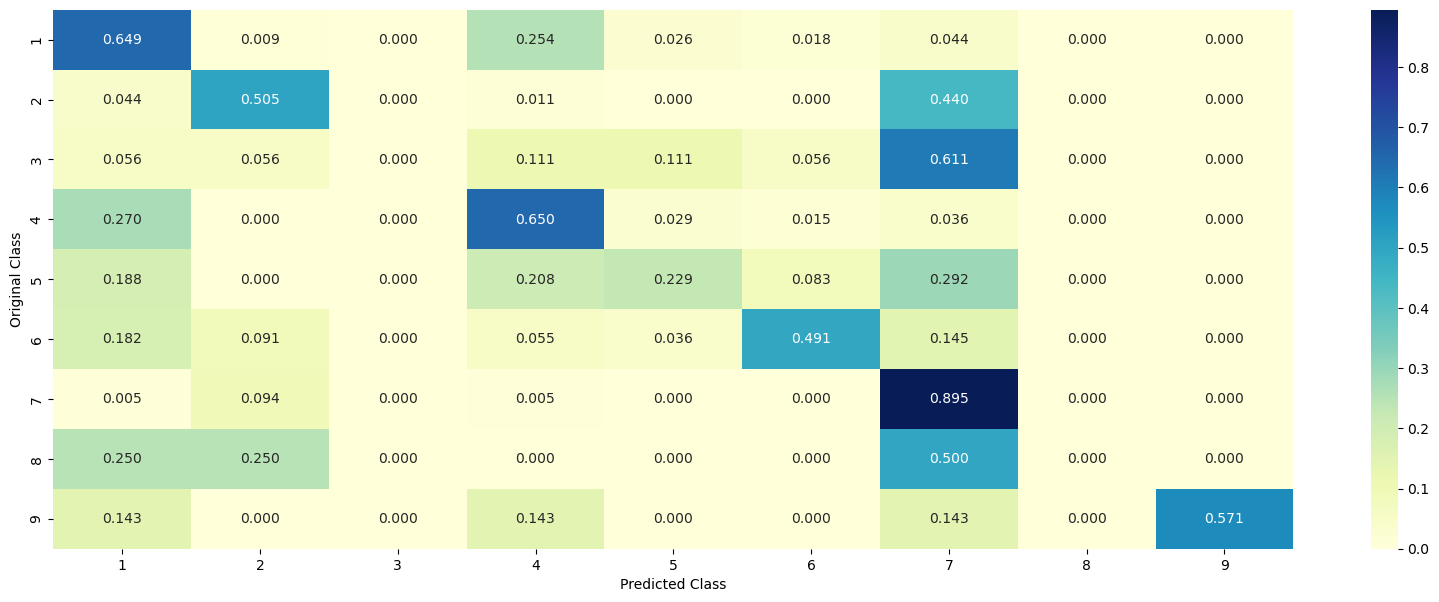

In [156]:
clf = SGDClassifier(alpha = alpha[best_alpha_idx], penalty='l2', loss='log_loss', random_state=42)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

# Support Vector Machines

For alpha = 1e-05
Log Loss: 1.2601625788454476
For alpha = 0.0001
Log Loss: 1.176317301234405
For alpha = 0.001
Log Loss: 1.12398880756568
For alpha = 0.01
Log Loss: 1.1279055872378603
For alpha = 0.1
Log Loss: 1.3604148586187412
For alpha = 1
Log Loss: 1.701138698448321
For alpha = 10
Log Loss: 1.7129830099344605
For alpha = 100
Log Loss: 1.7129831962463815


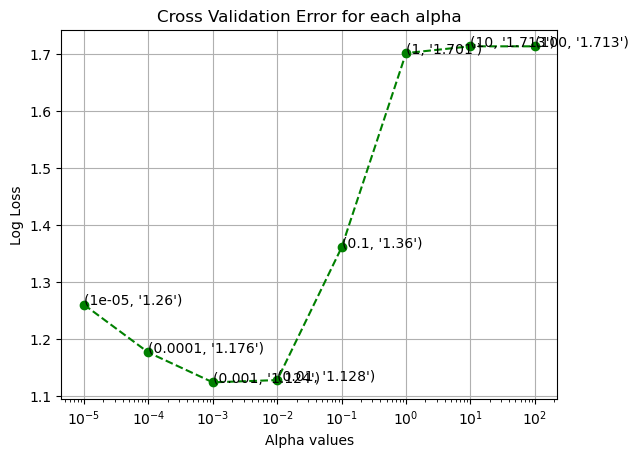

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.6082077223120199
For Cross Validation data with alpha=0.001, Log Loss: 1.1296857882005376
For Test data with alpha=0.001, Log Loss: 1.1500699712317992


In [157]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.12398880756568
Number of mis-classified points : 0.3233082706766917
____________________ Confusion Matrix --------------------


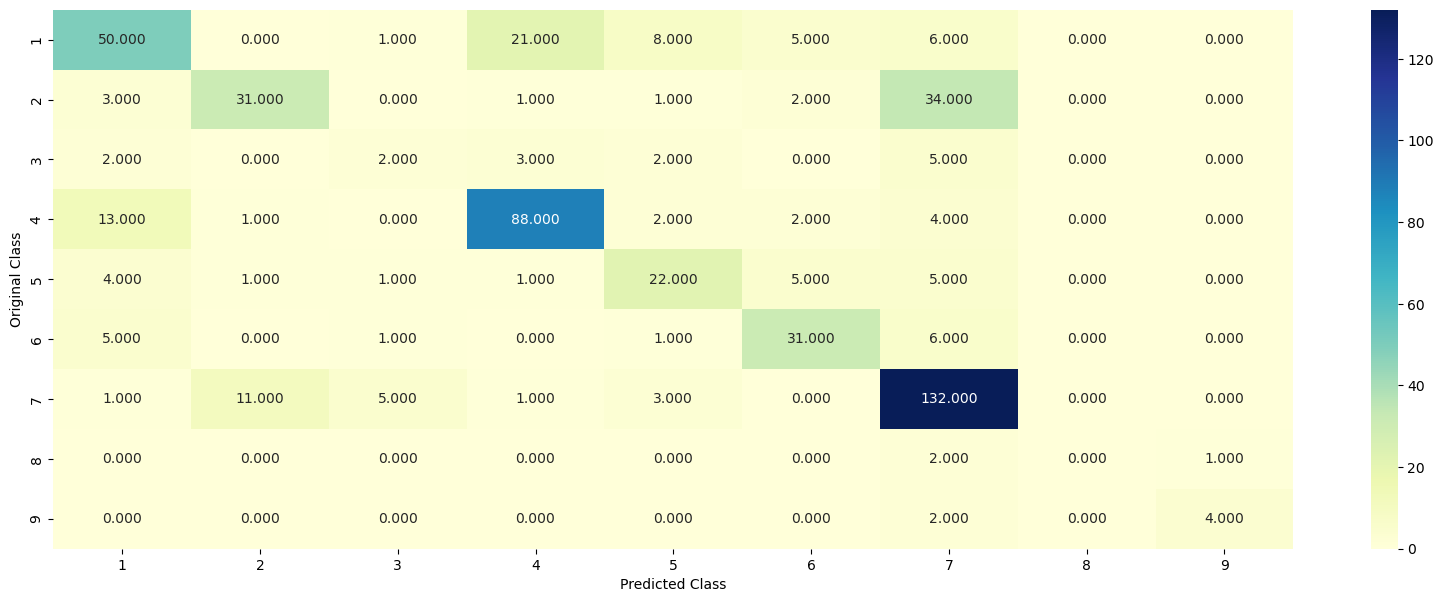

-------------------- Precision matrix (Columm Sum=1) --------------------


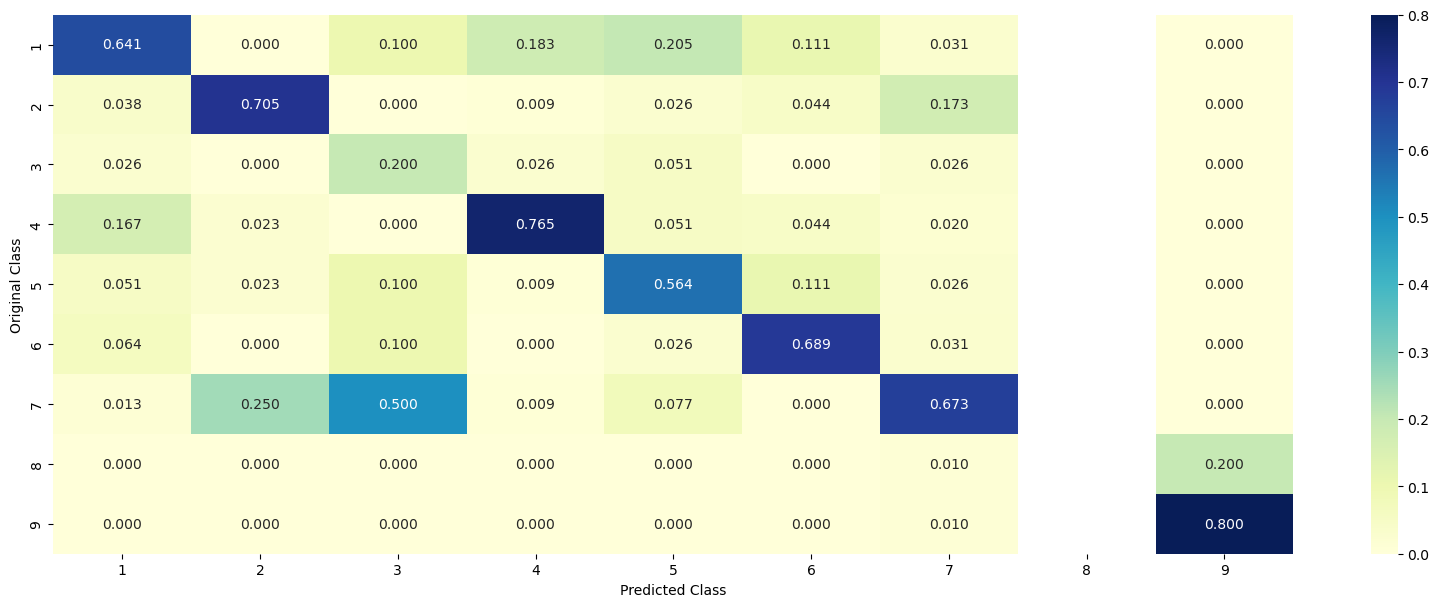

-------------------- Recall matrix (Row sum=1) --------------------


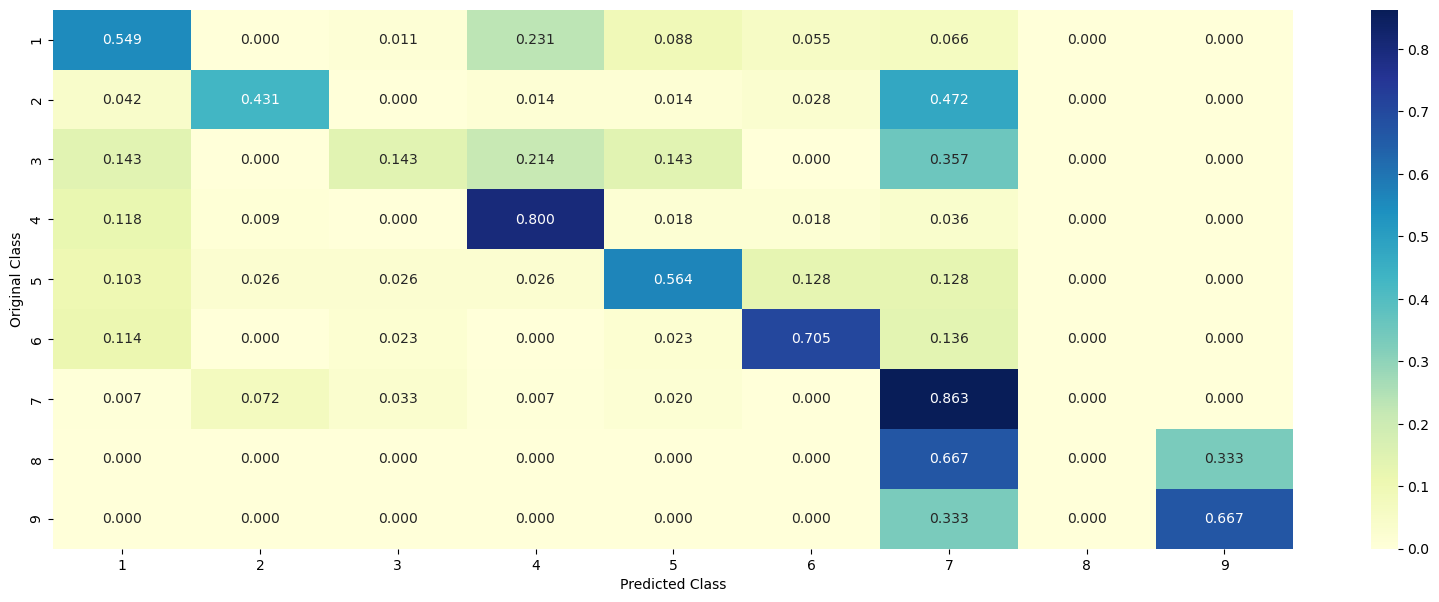

In [158]:
# Testing model with best hyper parameters

clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [162]:
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 100

no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]


Predicted Class : 7
Predicted Class Probabilities: [[0.097  0.1197 0.0187 0.2938 0.0466 0.0439 0.3683 0.0055 0.0065]]
Actual Class : 7


In [161]:
test_point_index = 50
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]


Predicted Class : 7
Predicted Class Probabilities: [[0.1072 0.0753 0.0163 0.0818 0.2305 0.0393 0.4366 0.0062 0.0068]]
Actual Class : 7


#### TFIDF Features

For alpha = 1e-05
Log Loss: 1.242300397344054
For alpha = 0.0001
Log Loss: 1.1675065170762449
For alpha = 0.001
Log Loss: 1.0972707714785617
For alpha = 0.01
Log Loss: 1.1585485658001013
For alpha = 0.1
Log Loss: 1.2885685660848203
For alpha = 1
Log Loss: 1.4879690996991592
For alpha = 10
Log Loss: 1.4874603408484122
For alpha = 100
Log Loss: 1.487470393491805


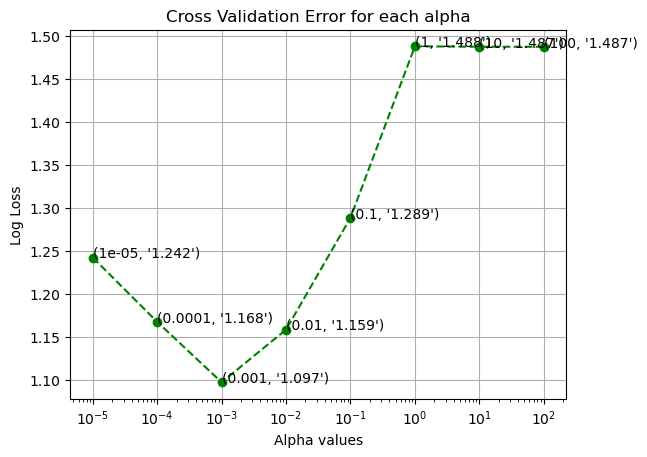

Best Alpha: 0.001
For Train data with alpha=0.001, Log Loss: 0.5414202582881965
For Cross Validation data with alpha=0.001, Log Loss: 1.0972707714785617
For Test data with alpha=0.001, Log Loss: 1.0975072081044102


In [163]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")


Log loss : 1.0975072081044102
Number of mis-classified points : 0.37142857142857144
____________________ Confusion Matrix --------------------


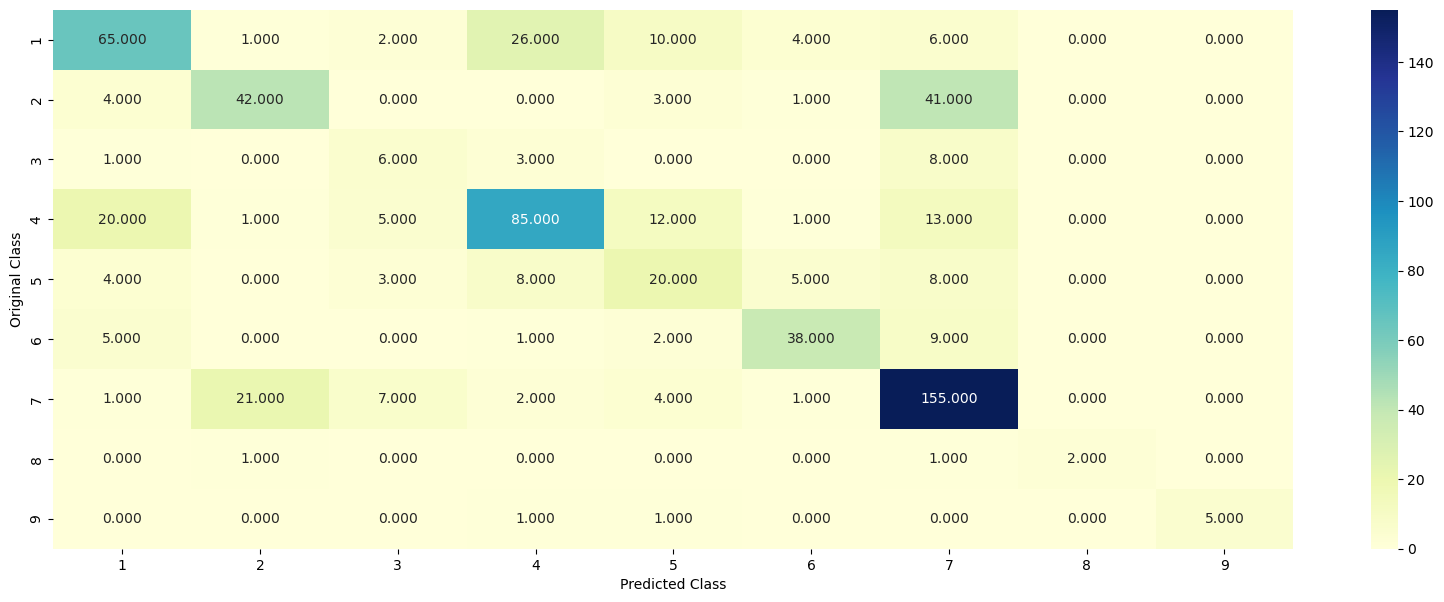

-------------------- Precision matrix (Columm Sum=1) --------------------


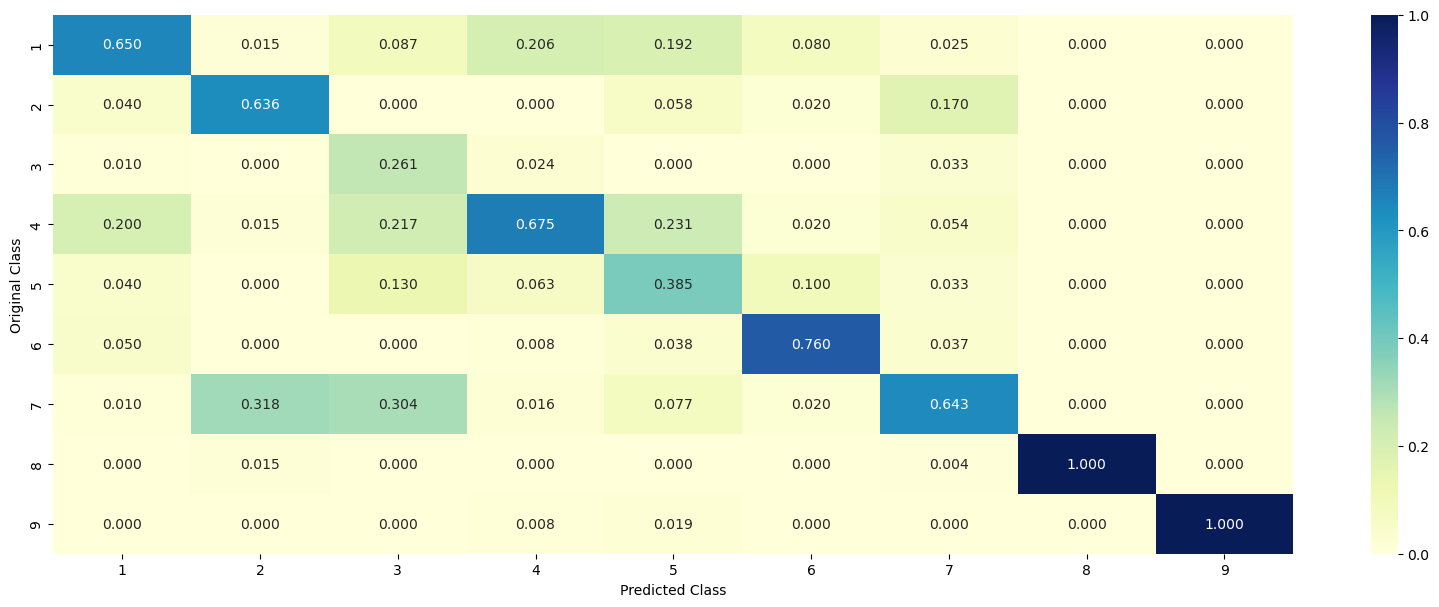

-------------------- Recall matrix (Row sum=1) --------------------


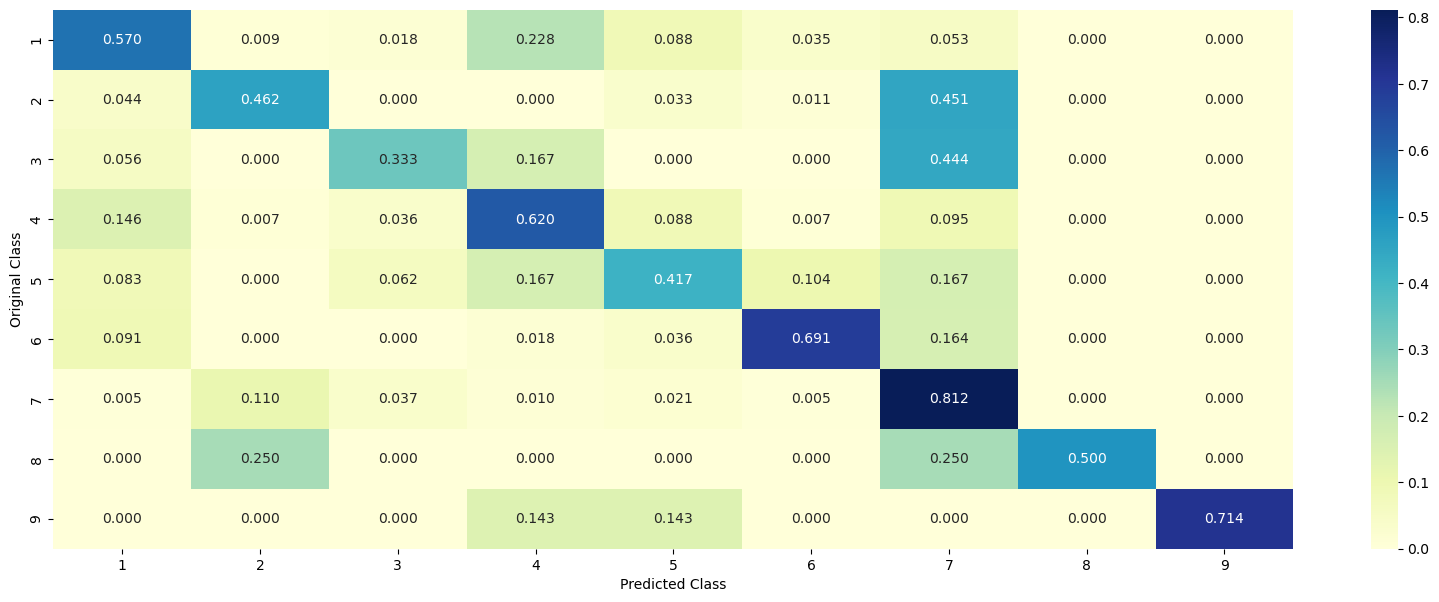

In [164]:

clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_tfidf, train_y, test_tfidf, test_y, clf)

#### TFIDF with top 1000 features

For alpha = 1e-05
Log Loss: 1.0829943884603528
For alpha = 0.0001
Log Loss: 1.024388297026226
For alpha = 0.001
Log Loss: 1.078200165037015
For alpha = 0.01
Log Loss: 1.3520418806308405
For alpha = 0.1
Log Loss: 1.5751961874085967
For alpha = 1
Log Loss: 1.711549519526143
For alpha = 10
Log Loss: 1.7115532467327201
For alpha = 100
Log Loss: 1.7115532350521152


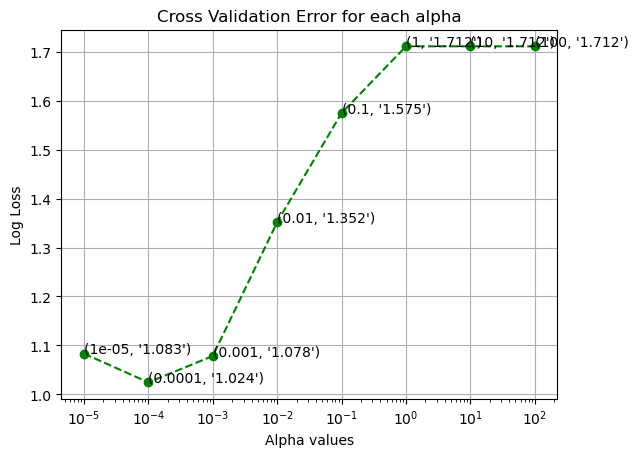

Best Alpha: 0.0001
For Train data with alpha=0.0001, Log Loss: 0.32114996382886984
For Cross Validation data with alpha=0.0001, Log Loss: 1.024388297026226
For Test data with alpha=0.0001, Log Loss: 1.0027379988624756


In [165]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []

# Loop through different alpha values
for i in alpha:
    print("For alpha =", i)

    # Train SGDClassifier with Hinge Loss (Linear SVM)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_tfidf_maxft, train_y)

    # Calibrate Classifier
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_tfidf_maxft, train_y)

    # Predict Probabilities on CV Data
    sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)


    sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)


    log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
    cv_log_error_array.append(log_loss_value)

    print("Log Loss:", log_loss_value)

# Plot CV Log Loss vs Alpha
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g', marker='o', linestyle='dashed')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], str(txt)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha values")
plt.ylabel("Log Loss")
plt.xscale("log")  # Use log scale for alpha
plt.show()

# Find Best Alpha
best_alpha_idx = np.argmin(cv_log_error_array)
best_alpha = alpha[best_alpha_idx]

print("Best Alpha:", best_alpha)

# Train Model with Best Alpha
clf = SGDClassifier(class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)


    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with alpha={best_alpha}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

Log loss : 1.0027379988624756
Number of mis-classified points : 0.3593984962406015
____________________ Confusion Matrix --------------------


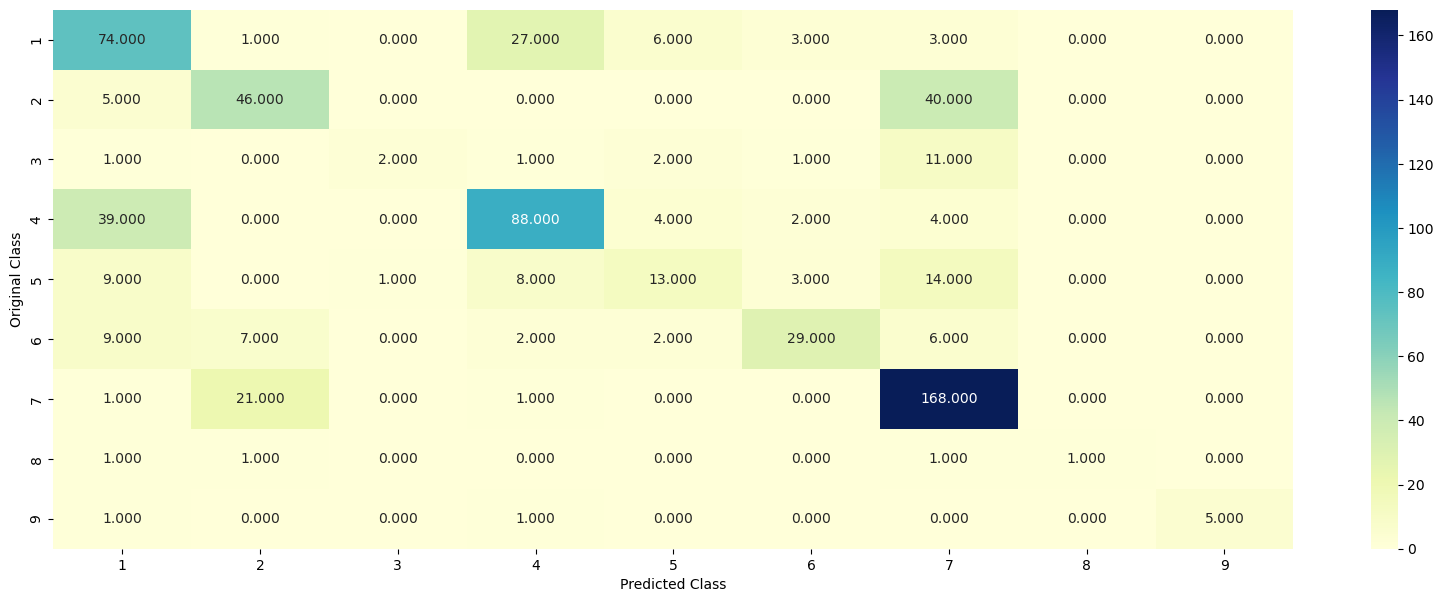

-------------------- Precision matrix (Columm Sum=1) --------------------


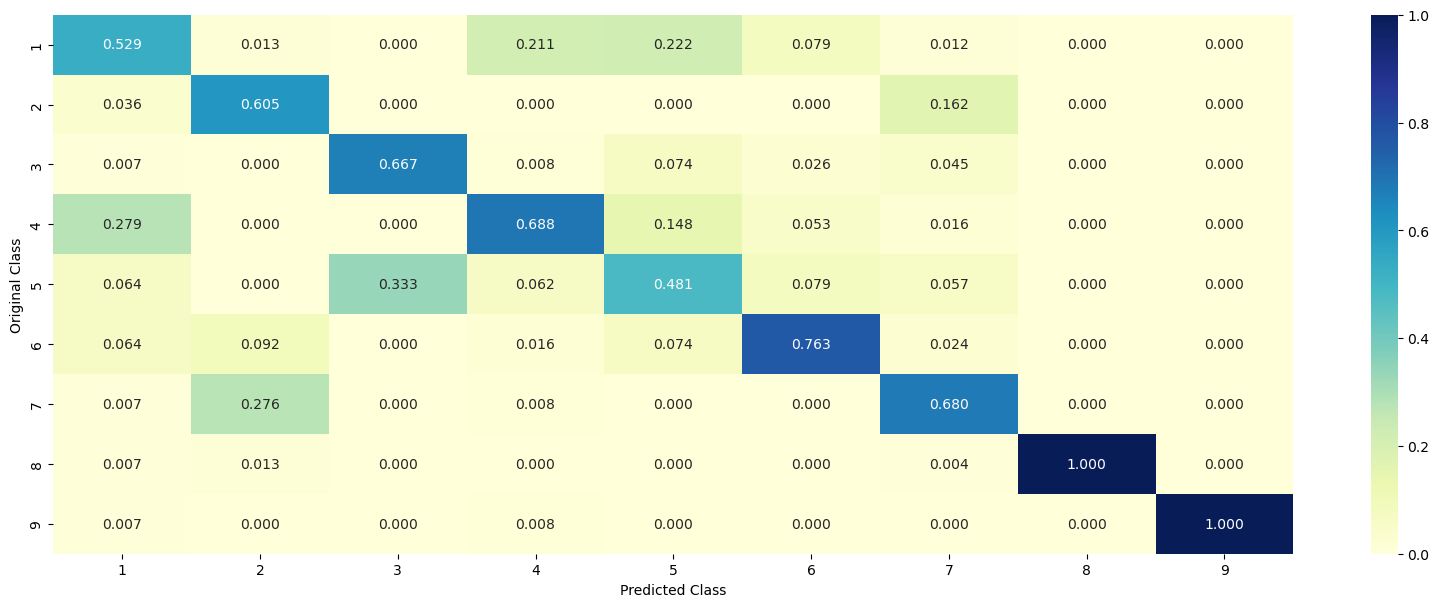

-------------------- Recall matrix (Row sum=1) --------------------


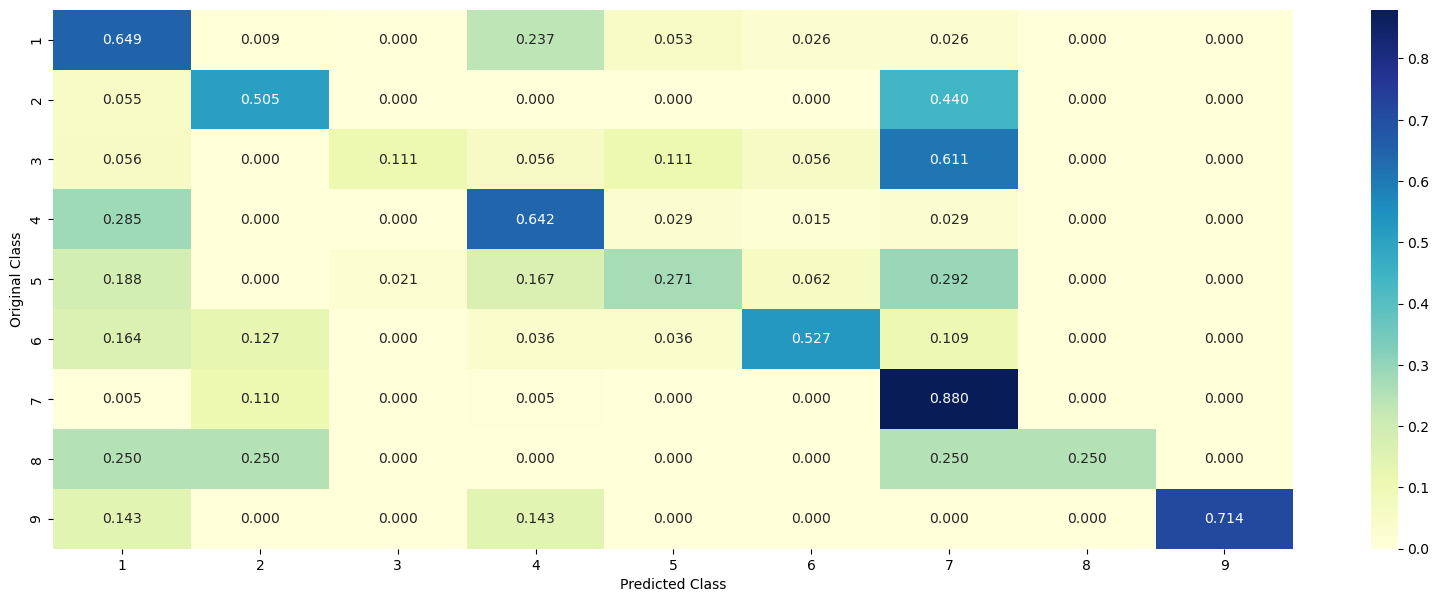

In [166]:
clf = SGDClassifier(alpha =best_alpha, penalty ='l2', loss='hinge', random_state = 42, class_weight ='balanced')
predict_and_plot_confusion_matrix(train_x_tfidf_maxft, train_y, test_tfidf_maxft, test_y, clf)

# Random Forest Classifier

## Hyper parameter tuning(One hot encoding)

In [ ]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_onehotCoding, train_y),
                           ("Cross Validation", cv_x_onehotCoding, cv_y),
                           ("Test", test_x_onehotCoding, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.2504891581414779
For n_estimators = 100, max_depth = 10
Log Loss: 1.1690795325839858
For n_estimators = 200, max_depth = 5
Log Loss: 1.2456676060706289
For n_estimators = 200, max_depth = 10
Log Loss: 1.1624202546450586
For n_estimators = 500, max_depth = 5
Log Loss: 1.2432395226816702
For n_estimators = 500, max_depth = 10
Log Loss: 1.1566080288032603
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2368912695909664
For n_estimators = 1000, max_depth = 10
Log Loss: 1.1572548470144222
For n_estimators = 2000, max_depth = 5
Log Loss: 1.2342604504032275
For n_estimators = 2000, max_depth = 10
Log Loss: 1.1578941266851912
Best n_estimators: 500, Best max_depth: 10
For Train data with n_estimators=500, max_depth=10, Log Loss: 0.6971736092128769
For Cross Validation data with n_estimators=500, max_depth=10, Log Loss: 1.1566080288032603
For Test data with n_estimators=500, max_depth=10, Log Loss: 1.1944668186529384


Log loss : 1.1944668186529384
Number of mis-classified points : 0.41353383458646614
____________________ Confusion Matrix --------------------


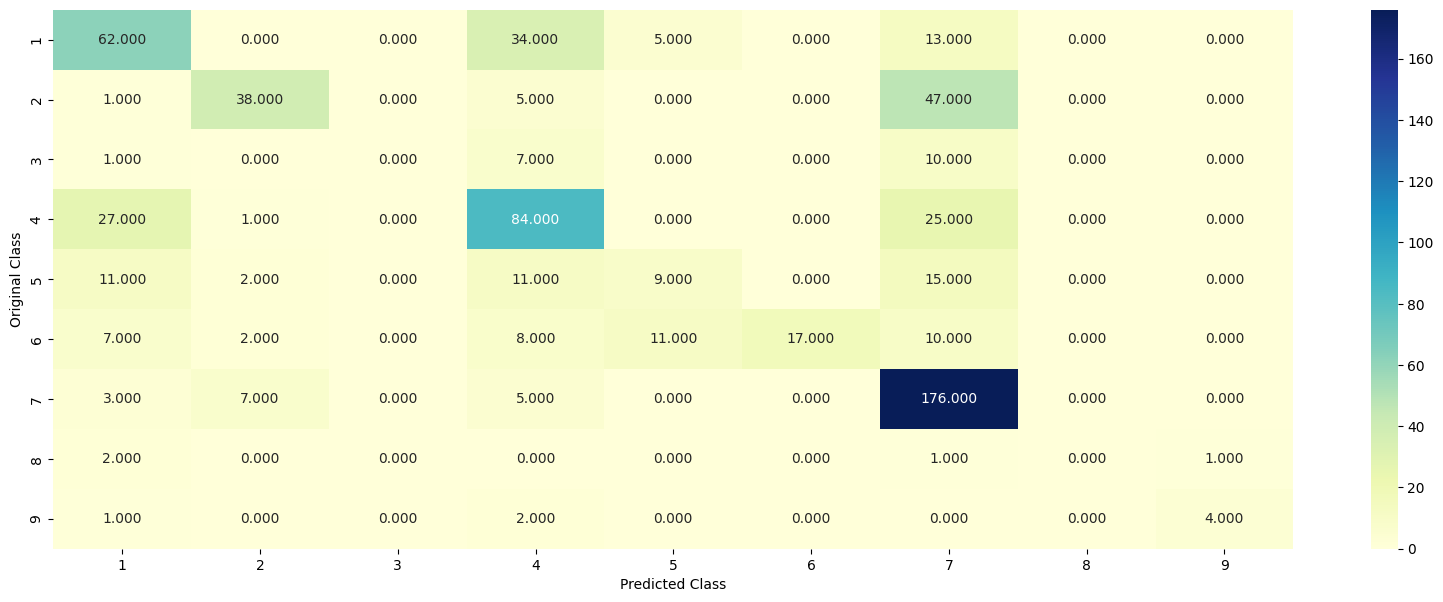

-------------------- Precision matrix (Columm Sum=1) --------------------


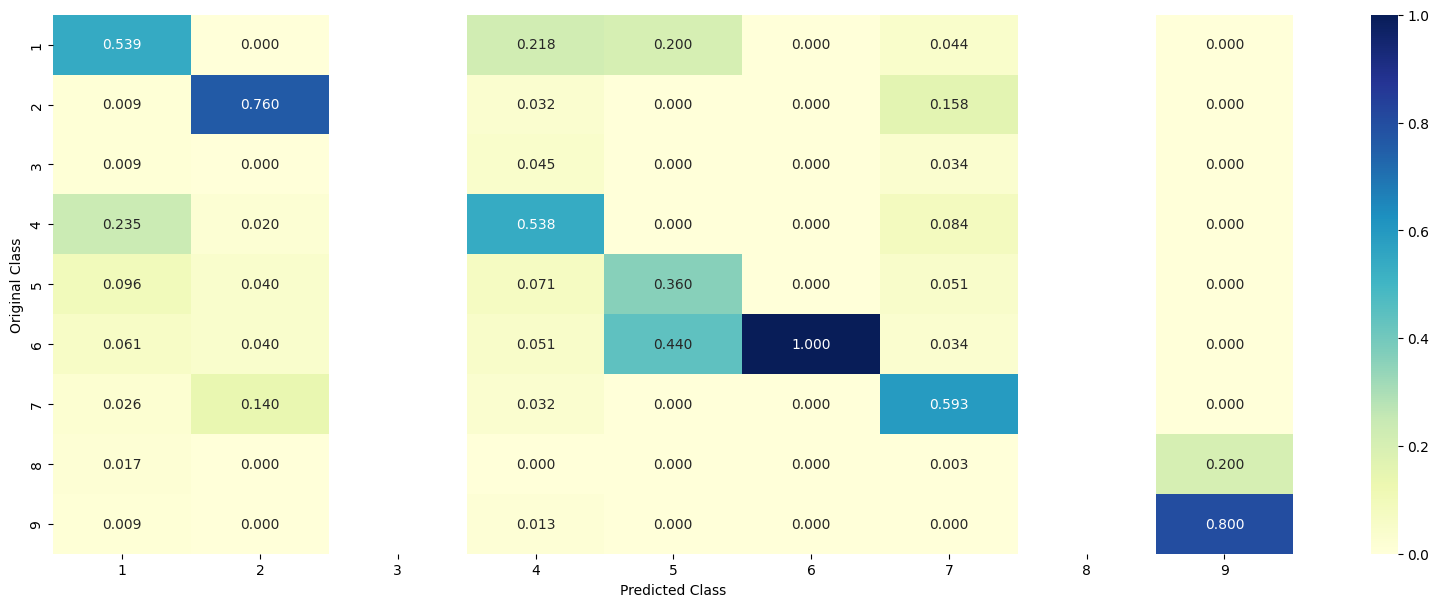

-------------------- Recall matrix (Row sum=1) --------------------


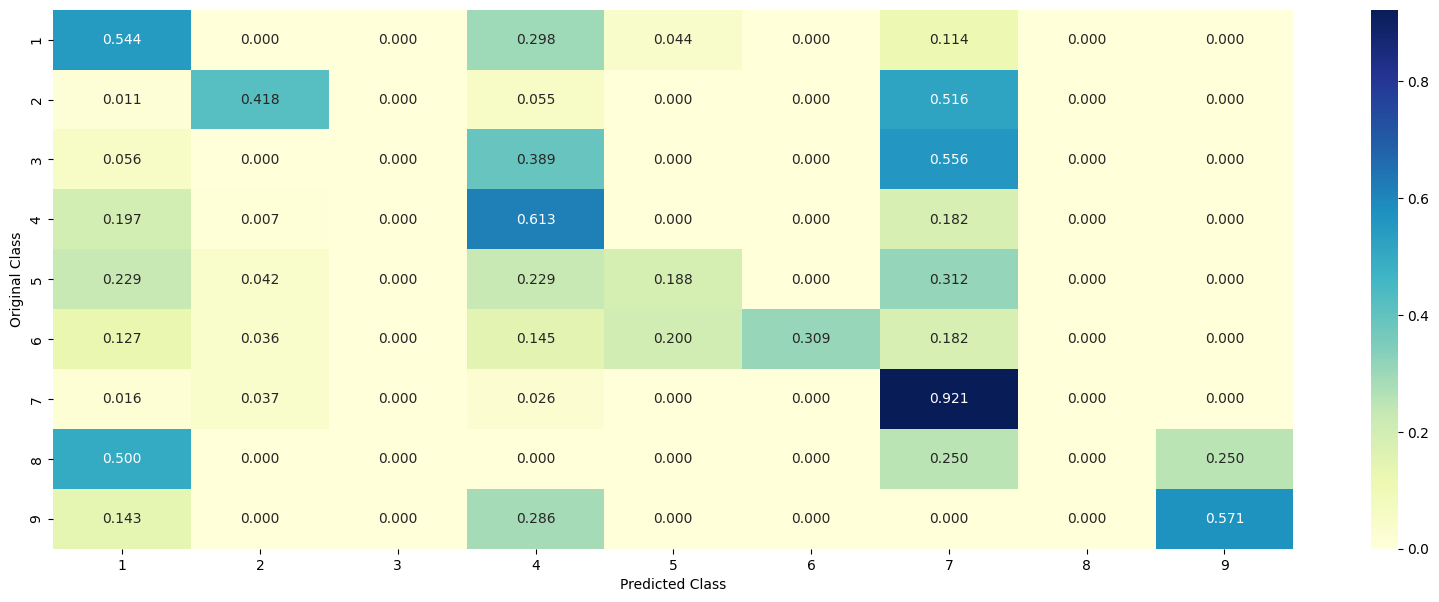

In [ ]:
# Testing model with best hyper parameters (One Hot Encoding)

clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,test_x_onehotCoding,test_y, clf)

In [ ]:
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini', max_depth=best_max_depth, random_state=42, n_jobs=1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)


Predicted Class : 1
Predicted Class Probabilities: [[0.2702 0.1688 0.028  0.1949 0.0637 0.0579 0.1949 0.0097 0.0119]]
Actual Class : 6


In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)


Predicted Class : 4
Predicted Class Probabilities: [[0.1398 0.0145 0.0394 0.6503 0.0867 0.0372 0.0223 0.0047 0.0051]]
Actuall Class : 4
--------------------------------------------------


#### TFIDF Features

In [ ]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf, train_y),
                           ("Cross Validation", cv_tfidf, cv_y),
                           ("Test", test_tfidf, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.2518805465552696
For n_estimators = 100, max_depth = 10
Log Loss: 1.1716854699199541
For n_estimators = 200, max_depth = 5
Log Loss: 1.2316617036864277
For n_estimators = 200, max_depth = 10
Log Loss: 1.1589737999523977
For n_estimators = 500, max_depth = 5
Log Loss: 1.215900546137149
For n_estimators = 500, max_depth = 10
Log Loss: 1.149310084128062
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2116514054057523
For n_estimators = 1000, max_depth = 10
Log Loss: 1.1504275252207268
For n_estimators = 2000, max_depth = 5
Log Loss: 1.209816036730695
For n_estimators = 2000, max_depth = 10
Log Loss: 1.1500674310012329
Best n_estimators: 500, Best max_depth: 10
For Train data with n_estimators=500, max_depth=10, Log Loss: 0.6511421834009045
For Cross Validation data with n_estimators=500, max_depth=10, Log Loss: 1.149310084128062
For Test data with n_estimators=500, max_depth=10, Log Loss: 1.1304801458420504


Log loss : 1.1304801458420504
Number of mis-classified points : 0.3894736842105263
____________________ Confusion Matrix --------------------


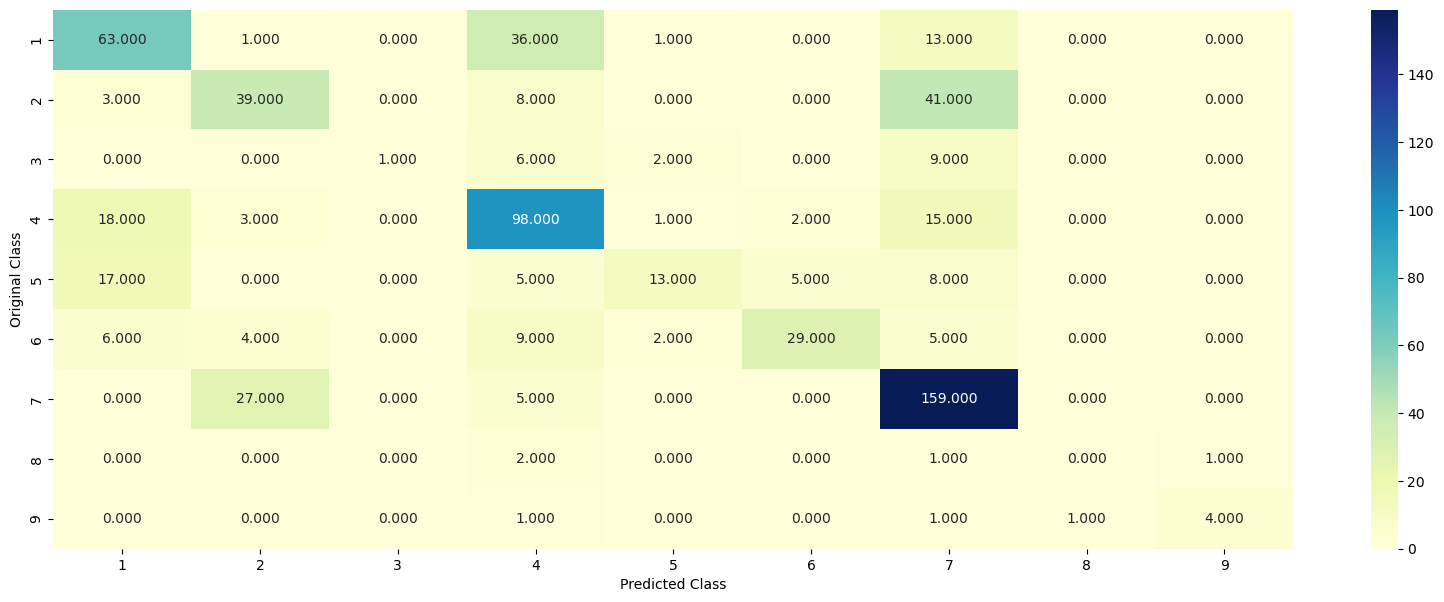

-------------------- Precision matrix (Columm Sum=1) --------------------


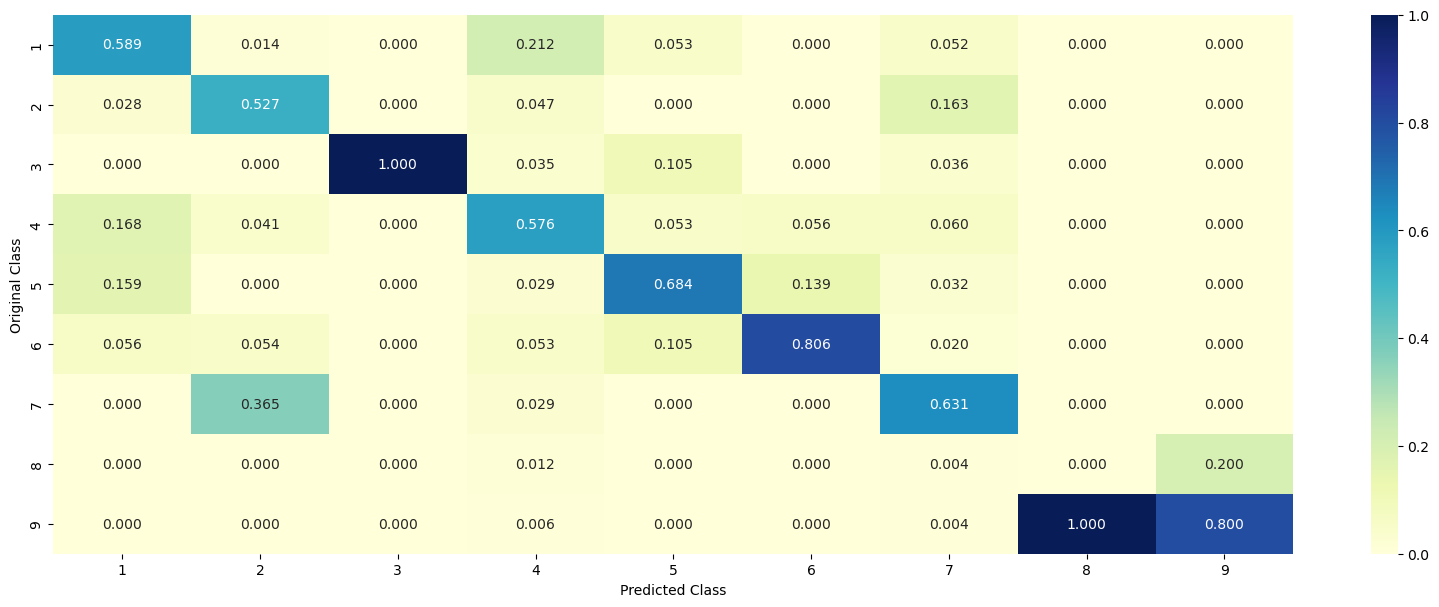

-------------------- Recall matrix (Row sum=1) --------------------


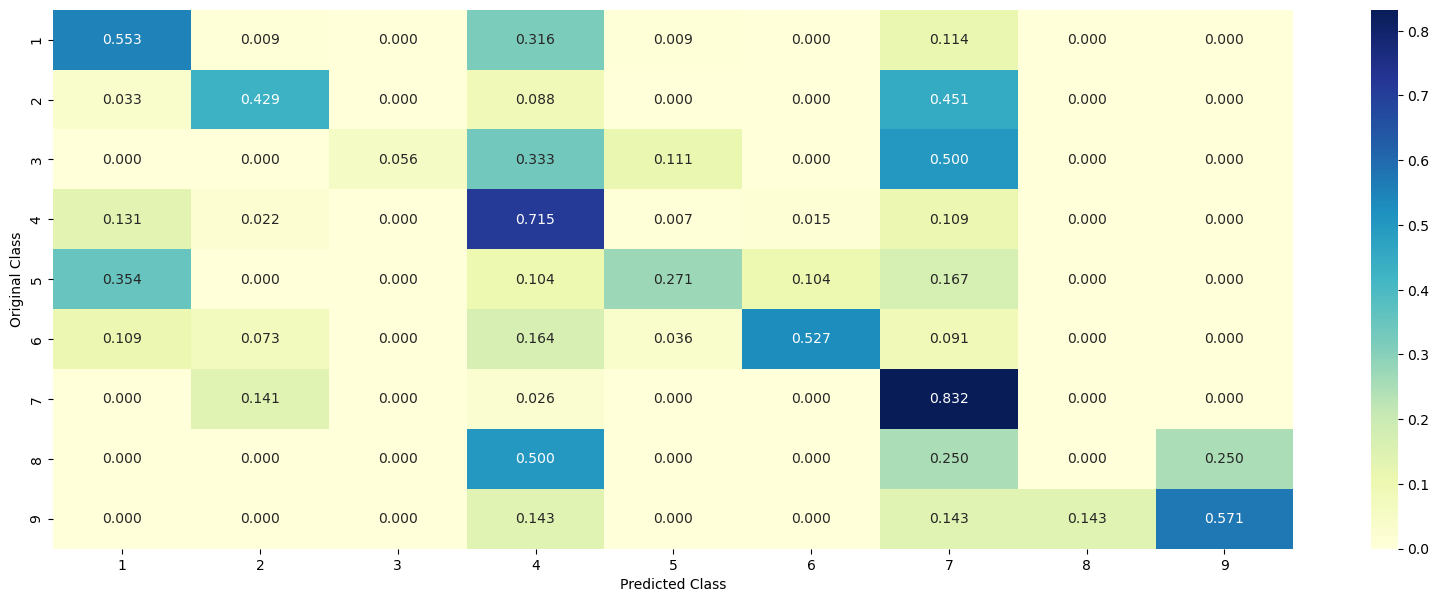

In [ ]:
clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_tfidf, train_y,test_tfidf,test_y, clf)

### TFIDF with top 1000 features

In [ ]:
alphas = [100,200,500,1000,2000]
max_depth_values = [5, 10]
cv_log_error_array = []
param_combinations = []  # Store (n_estimators, max_depth) pairs

# Loop through different hyperparameters
for n_estimators in alphas:
    for max_depth in max_depth_values:
        print(f"For n_estimators = {n_estimators}, max_depth = {max_depth}")
        # Train Random Forest Classifier
        clf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini',
                             max_depth=max_depth, random_state=42, n_jobs=-1)
        clf.fit(train_x_tfidf_maxft, train_y)
        # Calibrate the classifier
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_tfidf_maxft, train_y)
        # Predict Probabilities on CV Data
        sig_clf_probs = sig_clf.predict_proba(cv_tfidf_maxft)
        sig_clf_probs = np.clip(sig_clf_probs, 1e-15, 1 - 1e-15)
        # Compute Log Loss
        log_loss_value = log_loss(cv_y, sig_clf_probs, labels=clf.classes_)
        cv_log_error_array.append(log_loss_value)
        param_combinations.append((n_estimators, max_depth))
        print("Log Loss:", log_loss_value)

# Find Best Parameters
best_idx = np.argmin(cv_log_error_array)
best_n_estimators, best_max_depth = param_combinations[best_idx]
print(f"Best n_estimators: {best_n_estimators}, Best max_depth: {best_max_depth}")

# Train Model with Best Parameters
clf = RandomForestClassifier(n_estimators=best_n_estimators, criterion='gini',
                             max_depth=best_max_depth, random_state=42, n_jobs=-1)
clf.fit(train_x_tfidf_maxft, train_y)

# Calibrate Model
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_tfidf_maxft, train_y)

# Compute Log Loss for Train, CV, and Test Data
for dataset_name, X, y in [("Train", train_x_tfidf_maxft, train_y),
                           ("Cross Validation", cv_tfidf_maxft, cv_y),
                           ("Test", test_tfidf_maxft, y_test)]:

    predict_y = sig_clf.predict_proba(X)

    predict_y = np.clip(predict_y, 1e-15, 1 - 1e-15)

    print(f"For {dataset_name} data with n_estimators={best_n_estimators}, max_depth={best_max_depth}, Log Loss: {log_loss(y, predict_y, labels=clf.classes_)}")

For n_estimators = 100, max_depth = 5
Log Loss: 1.221314525133759
For n_estimators = 100, max_depth = 10
Log Loss: 1.2487895811644225
For n_estimators = 200, max_depth = 5
Log Loss: 1.2173490599647039
For n_estimators = 200, max_depth = 10
Log Loss: 1.2360194003405343
For n_estimators = 500, max_depth = 5
Log Loss: 1.2148149337310565
For n_estimators = 500, max_depth = 10
Log Loss: 1.2349468031242532
For n_estimators = 1000, max_depth = 5
Log Loss: 1.2116807285899172
For n_estimators = 1000, max_depth = 10
Log Loss: 1.2311579664871004
For n_estimators = 2000, max_depth = 5
Log Loss: 1.2126598245376365
For n_estimators = 2000, max_depth = 10
Log Loss: 1.2314737262297082
Best n_estimators: 1000, Best max_depth: 5
For Train data with n_estimators=1000, max_depth=5, Log Loss: 0.8608168712220825
For Cross Validation data with n_estimators=1000, max_depth=5, Log Loss: 1.2116807285899172
For Test data with n_estimators=1000, max_depth=5, Log Loss: 1.1925776526838106


Log loss : 1.1925776526838103
Number of mis-classified points : 0.44511278195488724
____________________ Confusion Matrix --------------------


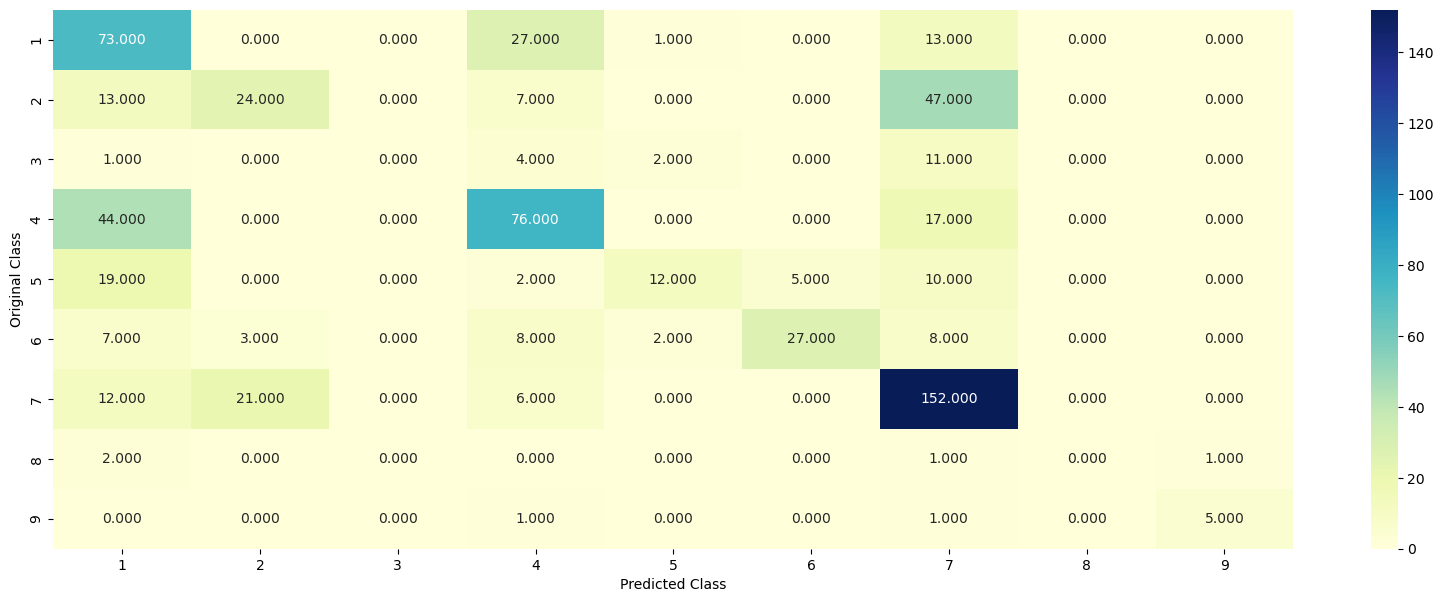

-------------------- Precision matrix (Columm Sum=1) --------------------


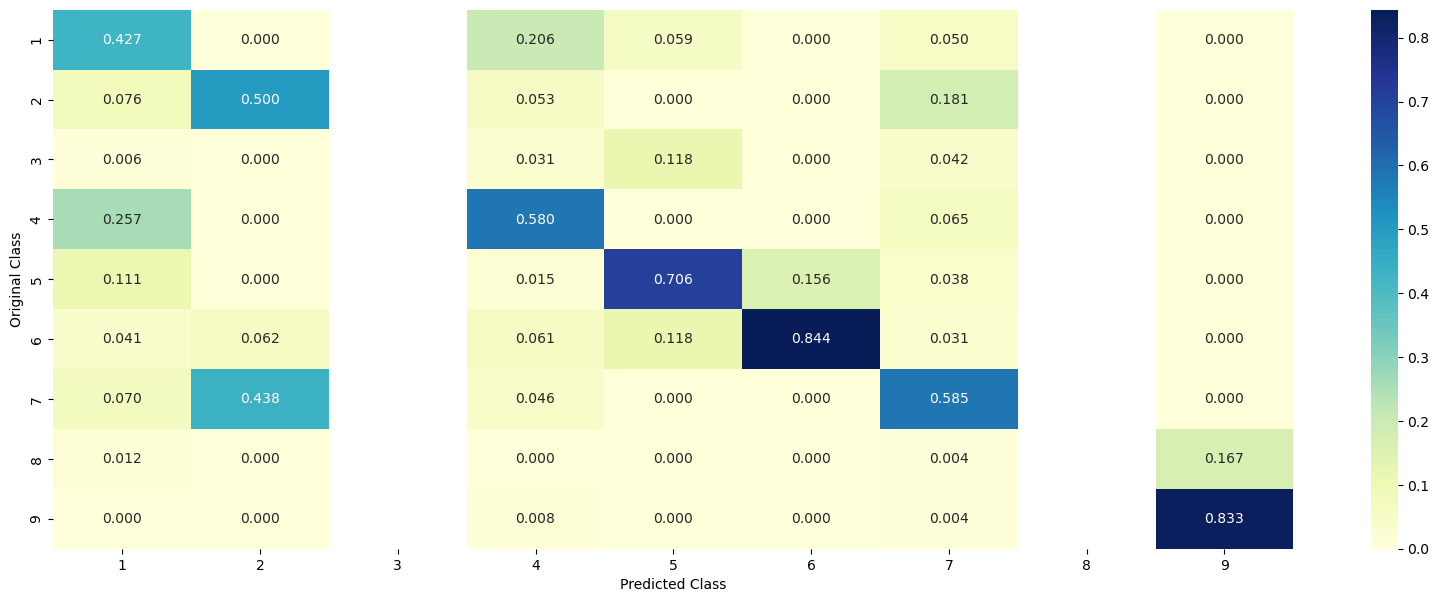

-------------------- Recall matrix (Row sum=1) --------------------


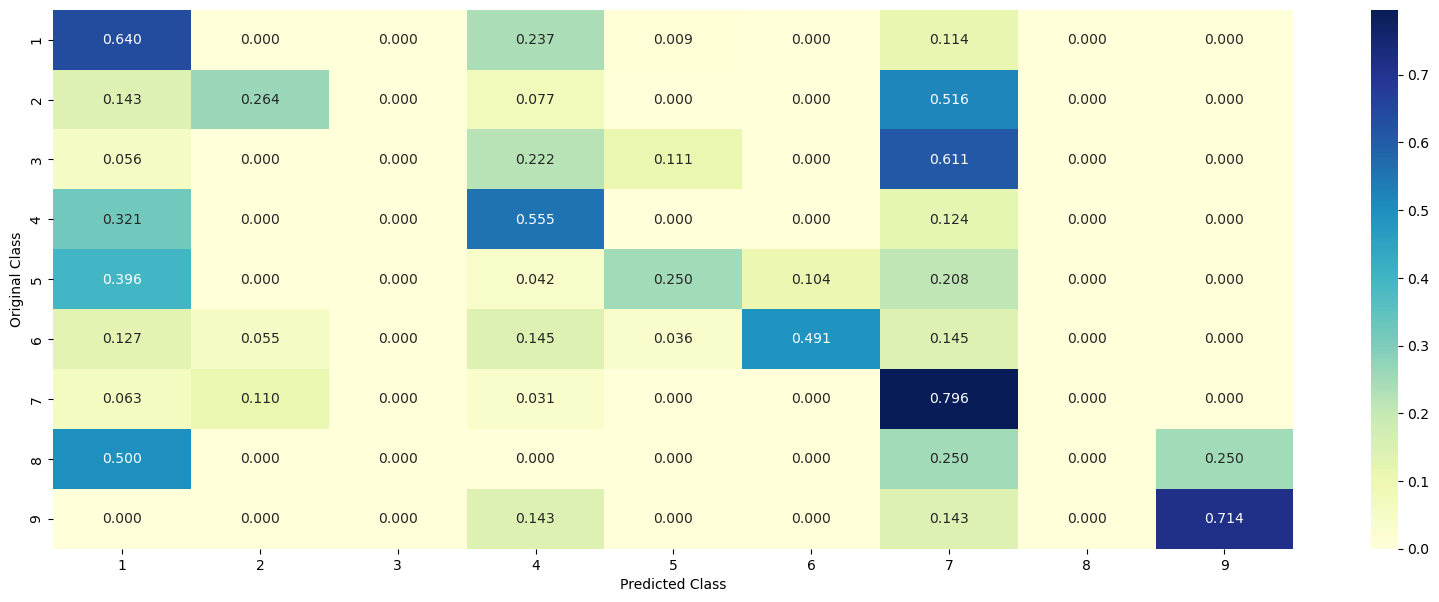

In [ ]:
clf = RandomForestClassifier(n_estimators=best_n_estimators,
                             criterion='gini',
                             max_depth=best_max_depth,
                             random_state=42,
                             n_jobs=1)
predict_and_plot_confusion_matrix(train_x_tfidf_maxft,train_y,test_tfidf_maxft,test_y, clf)